# Fatty Liver Disease (FLD) Study

- alcoholic vs non-alcoholic FLD, short: AFLD vs NAFLD


**Outline**

1. Study on liver disease types:
    1. Fibrosis
    1. Steatosis
    2. Inflammation
    
2. Two data sets with 
    1. clinical markers
    2. proteome information
    
**Highlighted Contents**
> In order to jump to highlighted sections, use a table of contents plugin (toc) for a structured view ([lab](https://github.com/jupyterlab/jupyterlab-toc) | [notebook](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html)). 
> Without data, but for easier navigation try to go to [colab](https://colab.research.google.com/).

2. Explore datasets
    1. Proteomics data
        - will be published to PRIDE
    2. Clinical data
        - not publically available
3. Models
    1. (3.2) Individual Models for three endpoints fibrosis, steatosis and inflammation
        - Cross-validation results
    2. (3.4) Final Model
        - final model used for DeLong-Test comparison and clinical follow-up evaluation


> Some data is hidden from the public output until it is cleared. `#hide`

In [1]:
import os
from pathlib import Path
CPUS = os.cpu_count()
RANDOMSTATE = 29

FOLDER_DATA_RAW = 'data/raw'
DATAFOLDER = 'data/processed'
os.makedirs('data/processed', exist_ok=True)
TABLEFOLDER = 'tables'
RESULT_FOLDER = 'results'
FIGURE_FOLDER = Path('figures')
FIGURE_FOLDER.mkdir(exist_ok=True)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model as skllm
from src.pandas import combine_value_counts
import sklearn.metrics as sklm
import sklearn.model_selection as sklms
from sklearn.model_selection import cross_val_predict

import ipywidgets as widgets
import tqdm

In [3]:
import src

# Explore datasets

Diagnostic comparators (existing best-in-class) biomarkers
- Fibrosis markers: transient elastography, 2-dimensional shear wave elastography, ELF test, FibroTest, FIB4 score, APRI score, Forns score, ProC3
- Inflammation markers: M30=caspase-cleaved cytokeratin-18 fragments, M65=total CK18, AST:ALT ratio, ProC3
- Steatosis: Controlled attenuation parameter

In [4]:
pd.set_option('max_columns', 9)

_folder = FOLDER_DATA_RAW
_index_col = 'Sample ID'

files = [file for file in os.listdir(_folder) if '.csv' in file]

if not files:
    print("No processed files found.")
else:
    w_data = widgets.Dropdown(options=files)

    show_data = src.widgets.create_show_data(index_col=_index_col, datafolder=_folder)
    out = widgets.interactive_output(show_data, controls={'file':w_data})

    data = show_data.__closure__[0].cell_contents
    w_cols = widgets.SelectMultiple(options=list(data.columns))

    show_selected_proteins = src.widgets.create_show_selected_proteins(data=data)

    out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})
    out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})

    # Updater
    def widget_updater(other_widget):
        """Picks first element from closure. other_widget is not used directly"""
        data = show_data.__closure__[0].cell_contents
        w_cols.options = list(data.columns)
        show_selected_proteins.__closure__[0].cell_contents = data

    _ = widgets.interactive_output(widget_updater, {'other_widget': w_data})

    display(widgets.VBox([w_data, out, w_cols, out_sel]))

## Olink proteomics data

### Load Complete Olink proteomics data

In [159]:
doubleIDkey = pd.read_csv('data/raw/DoubleIDkey.csv')
doubleIDkey['Participant ID']=doubleIDkey['Participant ID'].str.replace('SIPHON', 'ALD')
df_olink = pd.read_csv('/Volumes/auditgroupdirs/SUND-CBMR-Liver-Genetics-OUH/proteogenomics/GALA_wide.csv')

In [163]:
df_olink['Participant ID']=df_olink['SampleID'].str.replace('ALD', 'ALD_')
df_olink['Participant ID']=df_olink['Participant ID'].str.replace('HP', 'HP_')
df_olink['Sample ID']=df_olink['Participant ID'].map(dict(zip(doubleIDkey['Participant ID'], doubleIDkey['Sample ID'])))
df_olink=df_olink.drop(['Unnamed: 0', 'SampleID', 'Participant ID'], axis=1).set_index('Sample ID')

In [180]:
index_no = df_olink.columns.get_loc('IL10RB')
df_olink_prot = df_olink.iloc[:, index_no:]
df_olink_prot.rename_axis('Protein ID', axis=1, inplace=True)

In [231]:
df_olink_prot.head()

Protein ID,IL10RB,IFNg,NRTN,CCL23,LIF,IL8,IL4,CCL3,IL22_RA1,FGF23,...,uPA,CD6,CST5,ARTN,HGF,MCP1,IL1_a,IL2,CSF1,OSM
Sample ID,,,,,,,,,,,,,,,,,,,,,
Plate1_D5,5.895,6.132,1.112,10.169,0.460,4.537,0.543,5.146,2.074,2.214,...,9.098,6.098,6.630,1.096,7.878,11.535,-1.030,1.200,9.948,3.911
Plate7_C9,5.669,6.089,1.061,9.322,0.343,5.199,0.892,5.465,2.733,1.827,...,9.464,6.410,6.435,1.193,8.161,11.356,-1.100,1.207,10.267,3.885
Plate5_D11,6.124,6.859,1.213,10.931,0.589,4.739,0.367,6.142,1.822,2.097,...,8.991,6.163,6.658,0.841,7.770,11.355,-1.052,1.271,10.264,3.254
Plate2_H4,6.330,5.610,1.205,10.186,1.404,6.164,1.247,6.086,2.074,2.299,...,9.392,5.705,5.731,1.688,9.423,11.301,-0.935,1.472,10.723,6.742
Plate5_E11,6.493,7.307,1.213,10.414,0.205,4.227,0.470,5.552,3.751,2.405,...,9.350,6.886,7.677,1.484,8.104,11.173,-0.798,1.465,10.218,3.617


In [224]:
df_olink_prot.isnull().sum().sum()

38

In [237]:
df_olink_prot.loc[:, df_olink_prot.isna().any()].head()

Protein ID,IL22_RA1,IL24,IL13,MCP3
Sample ID,,,,
Plate1_D5,2.074,1.735,0.912,1.795
Plate7_C9,2.733,1.350,0.816,1.494
Plate5_D11,1.822,1.660,1.836,2.182
Plate2_H4,2.074,0.887,1.320,2.365
Plate5_E11,3.751,1.168,1.457,2.553


In [240]:
df_olink_prot.describe().T.sort_values(by='count', ascending=True)

,count,mean,std,min,25%,50%,75%,max
Protein ID,,,,,,,,
IL13,506.0,1.280,0.671,0.397,0.962,1.136,1.364,7.553
IL24,520.0,1.622,0.589,0.186,1.292,1.556,1.843,5.413
IL22_RA1,530.0,2.380,0.625,1.040,2.050,2.298,2.581,7.969
MCP3,530.0,2.257,0.670,0.838,1.809,2.207,2.583,6.375
IL10RB,531.0,6.429,0.425,4.865,6.143,6.407,6.700,7.576
...,...,...,...,...,...,...,...,...
IL10,531.0,3.982,0.746,2.012,3.522,3.852,4.322,9.986
STAMBP,531.0,4.228,0.743,2.779,3.727,4.107,4.531,8.613
CCL11,531.0,7.983,0.680,5.839,7.545,7.950,8.394,11.504


In [241]:
data_olink = df_olink_prot.dropna(axis=1)

In [242]:
data_olink.shape

(531, 88)

### Olink proteomics data imputation

<AxesSubplot:>

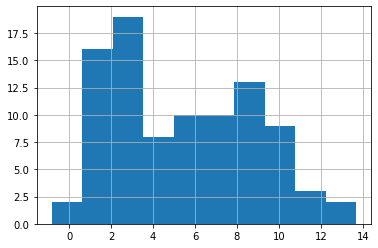

In [184]:
df_olink_prot.describe().loc['mean'].hist()

## Proteomics data

### Load Complete proteomics data

Full preprocessing pipeline

In [5]:
annotation_file = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(annotation_file_plasma.index, dtype=int)
display(annotation_file_plasma.head())
annotation_file_plasma.describe()

,File name,Sample ID,Groups,Species,Group2,Sample type
0,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A1,QC,Human,QC,Plasma
1,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A2,HP,Human,HP,Plasma
2,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A3,HP,Human,HP,Plasma
3,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A4,ALD,Human,ALD,Plasma
4,[5] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A5,ALD,Human,ALD,Plasma


,File name,Sample ID,Groups,Species,Group2,Sample type
count,603,603,603,603,603,603
unique,603,603,4,1,3,1
top,[87] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pl...,Plate1_E9,ALD,Human,ALD,Plasma
freq,1,1,355,603,459,603


The annotation file holds the filename for the the processed raw data by Skyline and some annotation, e.g. the `Sample ID`

In [6]:
annotation_file_plasma["Sample ID"]

0       Plate1_A1
1       Plate1_A2
2       Plate1_A3
3       Plate1_A4
4       Plate1_A5
          ...    
598    Plate7_C10
599    Plate7_C11
600    Plate7_C12
601     Plate7_D1
602     Plate7_D2
Name: Sample ID, Length: 603, dtype: object

The mapping for Protein ID to the gene ID is given by `report_plasma`

In [7]:
report_plasma = pd.read_csv(os.path.join(FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered')
report_plasma.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, inplace= True, axis=1)
report_plasma.head() 

,Protein ID,Gene names,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
0,A0A024R6I7,SERPINA1,1.0,1.0,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
1,A0A075B6I0,IGLV8-61,1.0,1.0,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
2,A0A075B6J9,IGLV2-18,1.0,1.0,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
3,A0A075B6R9;A0A0C4DH68,IGKV2D-24;IGKV2-24,1.0,1.0,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
4,A0A075B6S2;A2NJV5,IGKV2D-29;IGKV2-29,1.0,1.0,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06


Create mapping object (see if proteins are unique -> get function from other project)

In [8]:
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))
ids_.head()

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"


In [9]:
def length_(x):
    try:
        return len(x)
    except:
        return 0
    
count_groups_proteins = ids_.apply(lambda series_: series_.apply(length_))
count_groups_proteins

,Protein ID,Gene names
0,1,1
1,1,1
2,1,1
3,2,2
4,2,2
...,...,...
519,1,1
520,1,1
521,1,1
522,1,1


In [10]:
from src.pandas import combine_value_counts
combine_value_counts(count_groups_proteins)

,Protein ID,Gene names
0,NaN,2.0
1,318.0,499.0
2,121.0,11.0
3,44.0,3.0
4,20.0,2.0
5,7.0,3.0
6,6.0,1.0
7,1.0,NaN
8,1.0,NaN
10,1.0,NaN


- Protein IDs are always set
- two proteins have no annotations (Gene name count of 0 appears twice)
- the are some protein names which are mapped to the same gene. 
Let have a look at cases where a set of proteins was not mapped uniquely to one gene:

In [11]:
ids_.loc[count_groups_proteins['Gene names'] != 1]

,Protein ID,Gene names
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"
8,"[A0A087WWU8, P06753-2, Q5HYB6]","[TPM3, TPM3, DKFZp686J1372]"
21,"[A0A0A0MRZ8, P04433]","[IGKV3D-11, IGKV3-11]"
36,"[A0A0C4DH43, A0A0J9YVU5]","[IGHV2-70D, IGHV2-70]"
37,"[A0A0C4DH72, P01599]","[IGKV1-6, IGKV1-17]"
40,"[A0A0G2JIW1, P0DMV8, P0DMV9]","[HSPA1B, HSPA1A, HSPA1B]"
44,"[A0A0J9YY99, P01764, P01768, P0DP03]","[, IGHV3-23, IGHV3-30, IGHV3-30-5]"
48,"[A0A0U1RR32, A0A0U1RRH7, P04908, P0C0S8, P2067...","[HIST1H3D, HIST1H3D, HIST1H2AB, HIST1H2AG, HIS..."
70,"[B4DV12, F5GXK7, F5GYU3, F5H265, F5H2Z3, F5H38...","[UBB, UBC, UBC, UBC, UBC, UBC, UBC, UBC, UBB, ..."


In [12]:
from src.imputation import imputation_normal_distribution, log2, NP_LOG_FCT, IMPUTATION_MEAN_SHIFT, IMPUTATION_STD_SHRINKAGE
#imputation_normal_distribution??

In [13]:
# Report_plasma = pd.read_csv('raw/proteomics/plasma/20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv')
experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(lambda series_: series_.str.split(';').str[0])

In [14]:
report_plasma.describe()

,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A3.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A4.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
count,361.000000,327.000000,317.000000,340.000000,...,3.640000e+02,3.200000e+02,3.130000e+02,3.220000e+02
mean,2.124654,2.171254,2.192429,2.191176,...,3.939520e+06,4.541551e+06,4.727407e+06,4.267386e+06
std,0.933022,0.927444,0.912747,0.903245,...,4.108969e+07,4.513567e+07,4.711617e+07,4.104998e+07
min,1.000000,1.000000,1.000000,1.000000,...,1.908130e+02,5.826772e+02,7.995712e+02,2.039593e+02
25%,1.000000,1.000000,1.000000,1.000000,...,8.566062e+03,1.047221e+04,1.268499e+04,1.084710e+04
50%,3.000000,3.000000,3.000000,3.000000,...,4.154654e+04,6.404788e+04,6.787159e+04,6.053365e+04
75%,3.000000,3.000000,3.000000,3.000000,...,4.774295e+05,6.070775e+05,7.744870e+05,6.438288e+05
max,3.000000,3.000000,3.000000,3.000000,...,7.727070e+08,7.973126e+08,8.239611e+08,7.269720e+08


In [15]:
map_filenames_ids = dict(zip(annotation_file['File name'], annotation_file['Sample ID']))

Remove some measurements which are not intensities, but ... ?

In [16]:
data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

- rename column names to sample ID from annotation file
- set index to proteins

In [17]:
data_plasma_raw = data_plasma_raw.rename(mapper = map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)
data_plasma_raw.shape

(524, 603)

In [18]:
mask = data_plasma_raw.notna().sum(axis=1) > 603 * 0.6
mask.sum()

304

Filter at protein level for 60% data completeness across all runs

In [19]:
DATA_COMPLETENESS = 0.6
data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
# data_plasma_filtered #hide

Check how many the plates which will be discarded have:

In [20]:
mask_filtered_out = data_plasma_filtered.notna().sum() < 200
data_plasma_filtered.loc[:, list(mask_filtered_out)].describe().loc['count'].astype(int).sort_values()

Plate1_E1     80
Plate7_B6    114
Plate4_E3    117
Plate3_H2    119
Name: count, dtype: int64

In [21]:
data_plasma_raw.loc[:, mask_filtered_out].describe().loc['count'].astype(int).sort_values()

Plate1_E1     85
Plate4_E3    121
Plate3_H2    127
Plate7_B6    169
Name: count, dtype: int64

> Cutoff of 118 is next one where another sample would be discarded.

Filter at sample level for a total number of quantified protein groups above 200 (of 290).

In [22]:
MIN_N_PROTEIN_GROUPS = 200
print(f"Min No. of Protein-Groups in single sample: {MIN_N_PROTEIN_GROUPS}, i.e. a fraction of {MIN_N_PROTEIN_GROUPS/len(data_plasma_filtered)}")

Min No. of Protein-Groups in single sample: 200, i.e. a fraction of 0.6578947368421053


In [23]:
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
# data_plasma_filtered #hide

In [24]:
assert (data_plasma_filtered.dtypes != float).sum() == 0

In [25]:
# data_plasma_filtered = convert_to_numeric(data_plasma_filtered)
# data_plasma_filtered_log = np.log2(data_plasma_filtered)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
# data_plasma_filtered_log #hide

##### Imputation

- imputation is done before coefficient of variation (CV)
- is this sensible?

In [26]:
SCALE_DATA = False
if SCALE_DATA:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    data_plasma_filtered_log_imputed_np = scaler.fit_transform(data_plasma_filtered_log.values)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.copy()
    data_plasma_filtered_log_imputed.loc[:,:] = np.nan_to_num(data_plasma_filtered_log_imputed_np)
else:
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)
    assert data_plasma_filtered_log_imputed.loc['Q9Y6Z7', 'Plate1_A2'] - 9.770809 < 0.0001, 'Imputed value changed in comparison to previous run'

In [27]:
#ToDo: Look at distribution of imputed values vs non-imputed values by protein.
# create data viewer with overlap?

In [28]:
from pathlib import Path
file = Path('data/processed/plasma_processed.csv')
file.parent.mkdir(parents=True, exist_ok=True)

In [29]:
import logging
try:
    data_plasma_filtered_log_imputed.to_csv(file.absolute())
except PermissionError as e:
    logging.warning(f"No write permission to directory: {e}")

In [30]:
# data_plasma_filtered #hide

In [31]:
qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

In [32]:
CV_COEFFICIENT = 0.3
cv_selected = proteins_cv < CV_COEFFICIENT
print(f"Selected proteins # {cv_selected.sum()} of a total of # {len(cv_selected)}!")

Selected proteins # 219 of a total of # 304!


In [33]:
df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

In [34]:
PROTEOM  = 'data_ml_proteomics_cleaned.csv'

data_proteomics.to_csv(os.path.join(DATAFOLDER, PROTEOM))
# data_proteomics #hide

In [35]:
print("A maximum of {1} proteins in {0} samples can be used for proteomic models".format(*data_proteomics.shape))

A maximum of 219 proteins in 599 samples can be used for proteomic models


**Low intensities** below 8 (in log-scale)

In [36]:
intensities_below_8 = data_proteomics[data_proteomics < 8].dropna(how='all').dropna(how='all', axis=1)
# intensities_below_8 #hide

In [37]:
# data_proteomics.loc[intensities_below_8.index, intensities_below_8.columns] #hide

Data proteomics is the summary of the following processing steps:

1. protein is selected if shared betw. 60% of samples
2. sample is selected if it has at least 200 proteins
3. log-transform
4. imputation (imputation done per protein between runs)
5. selection using CV < 0.3

> Maybe create an automated report of the cutoffs.

In [38]:
summary_protein_preprocessing = [("Proportion protein has to be shared between samples" , DATA_COMPLETENESS),
                                 ("Minimum number of protein in single sample", MIN_N_PROTEIN_GROUPS),
                                 ("Maximum coefficient of variation (CV) for protein intensities", CV_COEFFICIENT),
                                 ("Logarithm employed for transformation", NP_LOG_FCT),
                                 ("Imputation: Mean-Shift", IMPUTATION_MEAN_SHIFT), 
                                 ("Imputation: Std-Dev. shrinkage", IMPUTATION_STD_SHRINKAGE)
                                ]

for descr, value in summary_protein_preprocessing:
    print('{}: {}'.format(descr, value))

Proportion protein has to be shared between samples: 0.6
Minimum number of protein in single sample: 200
Maximum coefficient of variation (CV) for protein intensities: 0.3
Logarithm employed for transformation: <ufunc 'log2'>
Imputation: Mean-Shift: 1.8
Imputation: Std-Dev. shrinkage: 0.3


### Load Protein GeneID Mapping

- UniProtID to Gene name mapping
- the assigned protein groups are mapped to mainly one, sometimes two genes -> Global Identifiers?!


In [39]:
key_ProteinID = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'ID_matching_key.csv'), 
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)
key_ProteinID.head()

,Gene names
Protein ID,
A0A024R6I7,SERPINA1
A0A075B6I0,IGLV8-61
A0A075B6J9,IGLV2-18
A0A075B6R9,IGKV2D-24
A0A075B6S2,IGKV2D-29


In [40]:
key_ProteinID.loc['A0A075B6R9']

Gene names    IGKV2D-24
Name: A0A075B6R9, dtype: object

Note that there are possibly alternative protein names, which are mapped to the same gene.

In [41]:
ids_.head()

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"


In [42]:
assert len(key_ProteinID) == len(ids_), "Both references should match at least in the number of proteins. "

## Clinical data
### Load Complete clinical data

In [43]:
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'

In [44]:
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'

f_data_clinic = os.path.join(FOLDER_DATA_RAW, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner']!=0.5]
# data_cli #hide

In [45]:
w_cols_cli = widgets.SelectMultiple(options=list(data_cli.columns))

def show_selected_markers(columns):
    if len(columns)> 0:
        display(data_cli[list(w_cols_cli.value)])
        display(data_cli[list(w_cols_cli.value)].describe())
    else:
        print('Select clinical markers')

out_cli = widgets.interactive_output(show_selected_markers, {'columns': w_cols_cli})
widgets.VBox([w_cols_cli, out_cli])

Select clinical markers


### Selected Clinical markers

Diagnostic comparators (existing best-in-class) biomarkers
- state-of-the-art (**SOTA**) Fibrosis markers: 
    - `te`: transient elastography (sona liver scan)
    - `swe`: 2-dimensional shear wave elastography
    - `elf`: ELF test
    - `ft`: FibroTest
    - `fib4`: FIB4 score
    - `apri`: APRI score
    - `forns`: Forns score
    - `p3np`: ProC3
- Inflammation markers:
    - M30=caspase-cleaved cytokeratin-18 fragments
    - M65=total CK18
    - AST:ALT ratio
    - ProC3
- Steatosis: Controlled attenuation parameter

In [46]:
#SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
SOTA_fibrosis = ['elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].count()

,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,
0.0,35,33,36,36,36,35
1.0,120,93,120,121,123,113
2.0,104,76,104,104,103,95
3.0,27,17,26,26,27,22
4.0,63,49,66,66,67,54


In [47]:
pd.set_option('max_columns', 20)
FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner', 
          'fib4', 'elf', 'ft', 'te', 'swe', 'aar','ast',
          'apri','forns','m30', 'm65', 'meld', 'p3np', 'timp1', 'cap' ]
# data_cli[FEATURES_ML].head() #hide

In [48]:
data_cli.groupby('group2')[FEATURES_ML].count()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
group2,,,,,,,,,,,,,,,,,,
ALD,352,352,360,353,350,268,342,332,353,354,354,357,268,266,360,320,320,206
HP,0,0,0,0,0,0,136,136,0,119,0,0,0,0,136,0,0,133


In [49]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Selected Demographics

In [50]:
demographics = data_cli[['age', 'bmi', 'gender_num']] # 1 is male
demographics.describe()

,age,bmi,gender_num
count,497.000000,487.000000,497.000000
mean,54.953722,27.194539,0.726358
std,10.433153,5.180561,0.446277
min,19.000000,13.737373,0.000000
25%,48.000000,23.849999,0.000000
50%,56.000000,26.799999,1.000000
75%,62.000000,30.286856,1.000000
max,75.000000,52.099998,1.000000


In [51]:
SELECTED_DEMOGRAPHICS = ['age', 'gender_num']
data_cli[SELECTED_DEMOGRAPHICS].head()

,age,gender_num
Sample ID,,
Plate6_G11,64,1
Plate1_F7,74,1
Plate6_D2,71,1
Plate6_C5,53,1
Plate4_F8,63,1


### Targets

In [52]:
fibrosis_score = data_cli.kleiner
inflamation_score = data_cli.nas_inflam
steatosis_score = data_cli.nas_steatosis_ordinal

In [53]:
TARGETS = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[TARGETS]
Y.describe()

,kleiner,nas_steatosis_ordinal,nas_inflam
count,360.000000,352.000000,352.000000
mean,1.902778,0.982955,1.855114
std,1.248506,1.045813,1.467221
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,3.000000,2.000000,3.000000
max,4.000000,3.000000,5.000000


In [54]:
from src.pandas import combine_value_counts
#combcombine_value_counts??

freq_targets = combine_value_counts(Y)
freq_targets.loc['Total',:] = freq_targets.sum()
freq_targets.to_excel(os.path.join(TABLEFOLDER, 'freq_endpoints_unique_values.xlsx'))
freq_targets

,kleiner,nas_steatosis_ordinal,nas_inflam
0.0,36.0,156.0,72.0
1.0,124.0,85.0,91.0
2.0,106.0,72.0,82.0
3.0,27.0,39.0,53.0
4.0,67.0,NaN,31.0
5.0,NaN,NaN,23.0
Total,360.0,352.0,352.0


Several binary features can be created.

target      | Scale   | unique values              | Binarization                 |  N samples
-----       | --------| ---------------            | -------------------------    |  ---------
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1) vs (F2, F3, F4)      |  360
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1,F2) vs (F3, F4)       |  360
inflamation | seven   | I0, I1, I2, I3, I4, I5     | (I0, I1) vs (I2, I3, I4, I5) |  352
steatosis   | five    | S0, S1, S2, S3             | (S0) vs (S1, S2, S3)         |  352


Variable naming: `<target>_greater-equal_<value>`

In [55]:
from src.pandas import create_dichotome
kleiner_ge_2     = create_dichotome(Y['kleiner'], 2)
kleiner_ge_3     = create_dichotome(Y['kleiner'], 3)
steatosis_ge_1   = create_dichotome(Y['nas_steatosis_ordinal'], 1)
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)

end_points = ['F2', 'F3', 'S1', 'I2']
dichotomies = [kleiner_ge_2, kleiner_ge_3, steatosis_ge_1, inflamation_ge_2]
targets_dict  = {k: v for k, v in zip(end_points, dichotomies)}

Frequencies of binary variables:

In [56]:
freq_targets = pd.DataFrame(
    {'kleiner>=2': kleiner_ge_2.value_counts(dropna=False, sort=False),
     'kleiner>=3': kleiner_ge_3.value_counts(dropna=False, sort=False),
     'steatosis>=1' : steatosis_ge_1.value_counts(dropna=False, sort=False),
     'inflamation>=2':inflamation_ge_2.value_counts(dropna=False, sort=False)
    })
freq_targets.loc['total'] = freq_targets.sum()
freq_targets

,kleiner>=2,kleiner>=3,steatosis>=1,inflamation>=2
0,160,266,156,163
1,200,94,196,189
total,360,360,352,352


### Clinical Cutoffs for targets

Cutoff for binary grouping of targets

target      | Scale   | unique values            | N samples
----------- | ------- | ----------------------   | -------
fibrosis    | five    | F0, F1, F2, F3, F4       | 360
steatosis   | five    | S0, S1, S2, S3           | 352
inflamation | seven   | I0, I1, I2, I3, I4, I5   | 352


In [57]:
file_cutoff_clinic = os.path.join(FOLDER_DATA_RAW, "clinical_marker_test_cut-offs.xlsx")
cutoffs_clinic = pd.read_excel(file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


In [58]:
markers_to_drop = []
for marker in cutoffs_clinic.index:
    if marker not in data_cli.columns:
        print(f"{marker}: Missing in clinics data.")
        markers_to_drop.append(marker)

proc3: Missing in clinics data.


`proc3` is not in data_clinic. drop this from the list of cutoffs! (Cutoff can be learned later)
Rename columns to desired endpoint name.

In [59]:
if markers_to_drop:
    cutoffs_clinic.drop(labels=markers_to_drop, inplace=True)
cutoffs_clinic.columns = ['F2', 'F3', 'I2', 'S1']
cutoffs_clinic

,F2,F3,I2,S1
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Extract certain cutoff for binary targets defined by column name:

In [60]:
cutoffs_clinic['F2'].dropna().to_dict()

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

See statistics (e.g. median) of SOTA-markers for clinical fibrosis assessment (represented by categories 0 to 4).

In [61]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Handle missing features of clinical data (Global Missing Pattern)

> No imputation of clinical features for now as only single clinical features are used in "univariate" models. Imputation is only sensible if several types of information are combined. Then one could use [`sklearn.impute.simpleImputer`](https://scikit-learn.org/stable/modules/impute.html)'s default `'mean'` strategy or alternatively one could replace missing values with zeros on the standardised data to zero mean and standard deviation of one.

Features are present to widely different degree. In order to be able to define global splits with the same pattern of missings over the features and targets by samples (here: patients), we define a missing pattern for stratification.

In [62]:
# FEATURES_CLINIC = ['ggt', 'alt', 'ast', 'alk', 'mcv', 'iga', 'igg', 'leu', 'glc']
FEATURES_CLINIC = cutoffs_clinic.index
data_cli[FEATURES_CLINIC].describe()

,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,aar,cap,alt,ast,m30m65_ratio
count,478.000000,468.000000,350.000000,268.000000,353.000000,354.000000,357.000000,320.000000,268.000000,266.000000,353.000000,339.000000,497.000000,473.000000,266.000000
mean,12.909623,11.406838,9.776571,0.347351,2.534051,0.702994,5.631933,13.262187,233.677756,685.670989,1.370283,274.348083,37.961771,44.262156,0.386805
std,16.416191,10.564157,1.508532,0.286632,3.023615,0.990803,2.390873,12.424449,297.008804,850.377366,0.764884,63.001900,32.346981,36.985152,0.207271
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,0.090000,100.000000,7.000000,12.000000,0.020000
25%,4.500000,5.600000,8.700000,0.100000,0.950000,0.240000,4.020000,6.775000,95.456402,271.321750,0.880000,228.000000,21.000000,24.000000,0.262500
50%,6.200000,7.050000,9.400000,0.245000,1.570000,0.405000,5.520000,8.950000,153.139500,440.100005,1.130000,277.000000,28.000000,32.000000,0.345000
75%,10.900000,11.700000,10.700000,0.542500,2.890000,0.770000,7.140000,14.425000,261.165740,835.044495,1.640000,321.000000,45.000000,48.000000,0.470000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,4.710000,400.000000,387.000000,331.000000,1.470000


We keep only samples for which any target is present. The other could be later used for verification of model prediction in the clinic.

In [63]:
patient_ids_w_target = data_cli[TARGETS].dropna(how='all').index
print(f"No. of samples without target variable: {len(data_cli) -len(patient_ids_w_target)} ")

No. of samples without target variable: 137 


We now define the set of variables of which we want to define missingness patterns:

In [64]:
FEATURES_CLINIC_ALL = list(FEATURES_CLINIC) + SELECTED_DEMOGRAPHICS + TARGETS
data_cli.loc[patient_ids_w_target, FEATURES_CLINIC_ALL].describe().sort_values(by="count", ascending=False, axis=1)

,alt,kleiner,gender_num,age,forns,apri,ast,aar,nas_steatosis_ordinal,nas_inflam,fib4,elf,te,swe,p3np,m30,ft,m65,m30m65_ratio,cap
count,360.000000,360.000000,360.000000,360.000000,356.000000,353.000000,353.000000,352.000000,352.000000,352.000000,352.000000,349.000000,341.000000,331.000000,319.000000,268.000000,268.000000,266.000000,266.000000,205.000000
mean,42.552778,1.902778,0.763889,55.536111,5.630197,0.703683,50.036827,1.367727,0.982955,1.855114,2.534773,9.777650,16.260704,13.842900,13.279937,233.677756,0.347351,685.670989,0.386805,287.107317
std,36.396417,1.248506,0.425282,10.684319,2.394013,0.992125,40.749948,0.764461,1.045813,1.467221,3.027889,1.510562,18.386198,11.711420,12.439905,297.008804,0.286632,850.377366,0.207271,63.930402
min,8.000000,0.000000,0.000000,19.000000,-1.540000,0.080000,12.000000,0.090000,0.000000,0.000000,0.270000,6.900000,2.100000,2.100000,1.500000,2.126260,0.020000,82.780701,0.020000,100.000000
25%,22.000000,1.000000,1.000000,49.000000,4.012500,0.240000,26.000000,0.877500,0.000000,1.000000,0.950000,8.700000,5.600000,6.500000,6.750000,95.456402,0.100000,271.321750,0.262500,245.000000
50%,33.500000,2.000000,1.000000,56.000000,5.515000,0.400000,37.000000,1.130000,1.000000,2.000000,1.570000,9.400000,8.700000,8.700000,9.000000,153.139500,0.245000,440.100005,0.345000,286.000000
75%,52.000000,3.000000,1.000000,63.000000,7.142500,0.770000,57.000000,1.640000,2.000000,3.000000,2.892500,10.700000,18.200001,15.850000,14.450000,261.165740,0.542500,835.044495,0.470000,331.000000
max,387.000000,4.000000,1.000000,75.000000,12.580000,11.630000,331.000000,4.710000,3.000000,5.000000,32.700001,14.800000,75.000000,75.599998,112.500000,3816.990000,0.980000,10015.900000,1.470000,400.000000


In [65]:
def ordered_missing_table(data:pd.DataFrame):
    """Order dataframe by data completeness (first column has most features) 
    and then return an encoding of completeness (1 = available, 0 0 not available)"""
       
    data_missing_table = data.notna().astype(int)
    var_ordered_by_completness = list(data.describe().loc['count'].sort_values(ascending=False).index)
    data_missing_table = data_missing_table.sort_values(by=var_ordered_by_completness)[var_ordered_by_completness]
    return data_missing_table.replace(0, pd.NA).convert_dtypes()

print("Used features: {}".format(", ".join(FEATURES_CLINIC_ALL)))
data_cli_missing_table = ordered_missing_table(data=data_cli.loc[patient_ids_w_target, FEATURES_CLINIC_ALL])
data_cli_missing_table = data_cli_missing_table.dropna(how='all', axis=0).dropna(how='all', axis=1)
# data_cli_missing_table #hide

Used features: te, swe, elf, ft, fib4, apri, forns, p3np, m30, m65, aar, cap, alt, ast, m30m65_ratio, age, gender_num, kleiner, nas_steatosis_ordinal, nas_inflam


In [66]:
data_cli_missing_table.describe().loc['count'].astype(int)

kleiner                  360
gender_num               360
age                      360
alt                      360
forns                    356
ast                      353
apri                     353
nas_inflam               352
fib4                     352
aar                      352
nas_steatosis_ordinal    352
elf                      349
te                       341
swe                      331
p3np                     319
m30                      268
ft                       268
m30m65_ratio             266
m65                      266
cap                      205
Name: count, dtype: int64

Compare both available data for proteomics and clinical features. We will add the availability of proteomics data as another feature to our missingness patterns.

In [220]:
data_proteomics.isna().any(axis=None)

False

In [68]:
in_both = data_proteomics.index.intersection(data_cli_missing_table.index)
samples_wo_proteomics_data = data_cli_missing_table.index.difference(in_both)
print("{} diagnosed patients have no valid proteome measure: {}".format(
    len(samples_wo_proteomics_data), 
    ", ".join(samples_wo_proteomics_data)
))

2 diagnosed patients have no valid proteome measure: Plate4_E3, Plate7_B6


In [69]:
HAS_QUANT_PROT = 'has_prot'
data_cli_missing_table[HAS_QUANT_PROT] = pd.Series(1, index=data_proteomics.index)

In [70]:
data_cli_missing_table.dropna(how='all').describe()

,kleiner,gender_num,age,alt,forns,ast,apri,nas_inflam,fib4,aar,...,elf,te,swe,p3np,m30,ft,m30m65_ratio,m65,cap,has_prot
count,360.0,360.0,360.0,360.0,356.0,353.0,353.0,352.0,352.0,352.0,...,349.0,341.0,331.0,319.0,268.0,268.0,266.0,266.0,205.0,358.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [71]:
data_cli_missing_table = ordered_missing_table(data_cli_missing_table)

In [72]:
data_cli_missing_strings = data_cli_missing_table.fillna(value=0)
data_cli_missing_strings = data_cli_missing_strings.astype(str)
stratifier = data_cli_missing_strings.apply(lambda x : x.str.cat(), axis=1)
# display(stratifier.head()) #hide
stratifier_tab = stratifier.value_counts()
stratifier_tab

111111111111111111111    115
111111111111111111110    107
111111111111111100001     30
111111111111111000001     23
111111111111110111110     19
111111111111101111110     12
111111111111111100000      6
111111111111111101001      5
111111111111011000001      5
111111111111111110111      4
111111111111100111110      4
111111000011111100001      2
111111000011011000001      2
111111000011111000001      2
111111111111111111001      2
111111111100011000001      2
111110111111111100001      2
111110111111111000001      1
111111111100110100001      1
111101111111011000001      1
111111111100111100001      1
111111111100110000001      1
111111111100101111110      1
111111111111110100000      1
111110111111111100000      1
111101000011011000001      1
111111111111111000000      1
111111111111110100001      1
111111111100111111110      1
111111110011111111111      1
111111111100111000001      1
111111111111110000001      1
111111111111101111111      1
111111111111111110110      1
11111111111110

We will have to get ride of the singletons (unique value only once observed). Possibly the grouping could be extended to the values up to 5.

In [73]:
unique_missing_patterns = list(stratifier_tab.index)

def match_observed(seq1, seq2):
    return sum(pos1 == pos2 for pos1, pos2 in zip(seq1, seq2))

assert match_observed("111111110011100001", "111111110011110010") == 15, "Failed"

In [74]:
stratifier.value_counts().min()

1

In [75]:
def update_stratifier(stratifier_var:pd.Series, threshold:int=None, verbose:bool=False):
    """Takes a stratifier variable, and assigns the pattern the less 
    often observed (defined by threshold or the minimum) to the closest other missing pattern.
    Clossness is defined by the number of features which are present/absent for the samples."""
    stratifier_var =stratifier_var.copy()
    stratifier_tab = stratifier_var.value_counts()
    current_minimum = stratifier_tab.min()
    if threshold is not None  and current_minimum >= threshold:
        logger.info("Threshold already reached.")
        return stratifier_var
    unique_missing_patterns = list(stratifier_tab.index)
    list_single_missing_patterns = stratifier_tab[stratifier_tab <= current_minimum].index
    for single_missing_pattern in list_single_missing_patterns:
        if verbose:
            logger.info(f"Find match for: {single_missing_pattern}")
        closest = 0
        for i, other_seq in enumerate(unique_missing_patterns):
            if not other_seq in list_single_missing_patterns:
                relatedness = match_observed(single_missing_pattern, other_seq)
                if relatedness > closest:
                    closest = relatedness
                    best = other_seq
        stratifier_var[stratifier_var == single_missing_pattern] = best
        if verbose:
            logger.info(f"Best match is : {best}")
    if threshold is not None:
        stratifier_tab = stratifier_var.value_counts()
        new_minimum = stratifier_tab.min()
        if new_minimum < threshold:
            stratifier_var = update_stratifier(stratifier_var, threshold=threshold)        
    return stratifier_var
# stratifier = update_stratifier(stratifier).value_counts()
stratifier = update_stratifier(stratifier, threshold=5, verbose=True)
stratifier.value_counts()

111111111111111111111    121
111111111111111111110    109
111111111111111100001     35
111111111111111000001     26
111111111111110111110     23
111111111111101111110     13
111111111111011000001     10
111111111111111100000      9
111111111111111101001      7
111111000011011000001      7
dtype: int64

Global stratification based on string. It won't be possible to distribute unique cases, which is why they were assigned to their closest papern. Then split models between endpoints are comparable as they are subsets of the global splits. This  garuantess:
1. By endpoint: Metrics for marker on one test set does not contain patients which are in the training set of a different marker.
2. By marker: Metrics for different endpoints on the test set does not contain training samples of a different endpoint.

In [76]:
from sklearn.model_selection import RepeatedStratifiedKFold

CV_FOLDS = 5
CV_REPEATS = 10

RANDOM_SEED = 123

rskf = RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) 
splits = list(rskf.split(data_cli_missing_table, stratifier))

In [77]:
cv_train_test_indices = list()
for train_indices, test_indices in splits:
    cv_train_test_indices.append(
     (stratifier.index[train_indices], stratifier.index[test_indices])
    )
cv_train_test_indices[0]

(Index(['Plate4_E3', 'Plate1_G11', 'Plate5_A2', 'Plate3_A10', 'Plate1_E10',
        'Plate1_E8', 'Plate5_C3', 'Plate4_H11', 'Plate2_C4', 'Plate4_G11',
        ...
        'Plate2_A2', 'Plate2_E6', 'Plate7_C6', 'Plate1_B7', 'Plate6_D11',
        'Plate7_A9', 'Plate2_E3', 'Plate3_E9', 'Plate2_B9', 'Plate3_G1'],
       dtype='object', name='Sample ID', length=288),
 Index(['Plate7_B6', 'Plate3_B6', 'Plate6_A10', 'Plate1_F8', 'Plate4_E11',
        'Plate1_D12', 'Plate1_B8', 'Plate3_E12', 'Plate6_C5', 'Plate5_A4',
        'Plate1_D5', 'Plate4_A7', 'Plate3_D6', 'Plate3_H10', 'Plate4_C8',
        'Plate1_H3', 'Plate7_A6', 'Plate5_B10', 'Plate5_F9', 'Plate5_H8',
        'Plate5_B2', 'Plate2_H5', 'Plate4_D4', 'Plate3_B8', 'Plate2_C11',
        'Plate1_G8', 'Plate2_G3', 'Plate5_E12', 'Plate4_F8', 'Plate4_G8',
        'Plate2_G1', 'Plate4_C3', 'Plate6_B9', 'Plate2_A12', 'Plate7_C10',
        'Plate3_F5', 'Plate4_B10', 'Plate4_E9', 'Plate4_F1', 'Plate7_C9',
        'Plate5_G6', 'Plate1_H8', 'Plate

## Visualization of data

Look at UMAPs with labels from disease categories.
  - Does the assigned disease correspond to certain groups
 
For clinical data, on could look at a selection of scatter plots in order to see if it is feasible to separate some groups based on two features.

In [78]:
#ToDo
#import umap

# Models

Different _experimental_ setups for prediction models will be compared. First, for the target **fibrosis**. Fibrosis is reported on a five-point scale from stage F0 to F4.

ML setup binary    | HP  | F0  | F1  | F2  | F3  | F4
--- | --- | ---    | --- | --- | --- | ---
HP-F0-F2 vs F3-F4  | c   | c   | c   | c   | t   | t    
F0-F2 vs F3-F4 (advanced)    |     | c   | c   | c   | t   | t
F0-F1 vs F2-F4 (significant)    |     | c   | c   | t   | t   | t

In the table, c stands for control  and t for target. The clinical relevance is to distinguish different 
stages of disease. The question is wheater one should include a healthy, untested patient cohort can help building a 
classification model, as e.g. for fibrosis the general prevalence in the population is between 6 to 7 percent. Alternatively a _multi-task model_ with having 5 classes/end-points can be fit.


In addition to fibrosis, the endpoints **steatosis** and **inflamation** can be predicted.

target      | Scale   | unique values              | N samples
-----       | --------| ---------------            | -------
fibrosis    | five    | F0, F1, F2, F3, F4         | 
steatosis   | five    | S0, S1, S2, S3, S4         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | 


What is population of interest?
- population at risk
- general population (which we do not have as a "random" sample)


## Preparation: Classifiers and Evaluation Functionality

### Predefined (Tree-based classifiers, SVMs, GLMs)
- Select Classifier by cross-validation using [sklearn functionality](https://scikit-learn.org/stable/model_selection.html#model-selection)

In [79]:
clf_lr    = skllm.LogisticRegression(random_state=0, solver='liblinear')
clf_lr_key = 'Logistic'

# specify more sklearn classifiers if you need
clf_sklearn = {clf_lr_key: clf_lr}

[Refitting](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#refitting-and-updating-parameters) the same estimator by invocing it `fit`-method overwrites the previously learned weights.

### Custom Threshold-based classification
Create a classifier based on the threshold which is compatible with the basic scikit-learn functionality, see [instructions](https://scikit-learn.org/stable/developers/develop.html)

Example for using the cutoff of Fibrosis >=2 from the cutoff-table:

In [80]:
cutoffs_clinic.loc['te','F2']

7.0

In [81]:
from src.threshold_classifier import ThresholdClassifier
clf_te = ThresholdClassifier(threshold={'te':7.0})
print(clf_te.threshold)
clf_te.fit(data_cli.fillna(value=0))
y_pred = clf_te.predict(data_cli)
clf_te.predict_proba(data_cli)[:4] # no scores, either 0 or 1 as cutoff is just compared

{'te': 7.0}


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Note: Having only one feature for threshold classification does make the definiton of a cutoff unnecessary. AUC-ROC statistics are not meaningful withouth scores.

In [82]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ThresholdClassifier)

### Confusion Matrix

In [83]:
from src.scoring import ConfusionMatrix

How to use it, e.g. for using a clinical marker cutoff for fibrosis:

In [84]:
y_true = data_cli.kleiner > 2.0

# y_pred defined as Threshold-example
cm_f2_te = ConfusionMatrix(y_true, y_pred)
print("As DataFrame:")
display(cm_f2_te.as_dataframe)
print("Plain:\n",cm_f2_te)

As DataFrame:


pred,0,1
true,,
0,280,123
1,9,85


Plain:
 [[280 123]
 [  9  85]]


### Cross-Validation Procedure

*Note on Cross-Validation Procedure*
- Comparing the performance on random splits of the entire data will lead to overconfident predicitons.
- Performing the Cross-Validation only on a `Train`-split would allow to have a better evaluation on the test dataset. 
- Cutoff calibration would need a validation split


##### Cutoff Specification
> in clinical setting, false-alarms are preferrable than missed detections. Yes we should find a way to customize the cutoffs
> to have a high sensitivity but also decent specificity, but I guess it risks over-tuning on this specific dataset?  
> Can one ramp over and find the optimal based on F1 score? Would MCC be a better alternative?  
> (Author?)

#### Selected Metrics for Binary Classification evaluation

In [85]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']
scoring

['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']

We build a dictionary of the scoring functions for later use:

#### Define population in order to obtain comparable splits of the data

The common functionality provided by `sklearn` does not allow for [nested stratification](https://stackoverflow.com/a/45526792/9684872). `RepeatedKFold` is splitting based on the data in the target variable.
One solution is to encode a sample with missing target or feature values explicitly into the target variable, but this is not feasible for many different sets of feature and target variables (here each marker-variable with each target is a set).

Data has to be aligned for computation. Due to missing values on some features, the runs are not directly comparable.

In [86]:
_y = kleiner_ge_2
_X = data_cli.te.to_frame().fillna(0)
in_both = _y.index.intersection(_X.index)
_X = _X.loc[in_both]

e.g. for clinical marker

In [87]:
from src.cross_validation import run_cv_binary_simple, _get_cv_means
clf = {**{'f2_te': clf_te}, **clf_sklearn}
print("Klassifiers:", ", ".join(clf.keys()))

result_dict = run_cv_binary_simple(clf, X=_X, y=_y, cv=5, scoring=scoring, return_estimator=True)
result_dict.keys()

Klassifiers: f2_te, Logistic


dict_keys(['f2_te', 'Logistic'])

In [88]:
_get_cv_means(result_dict).sort_values(('test_f1', 'mean'))

variable    fit_time           score_time           test_precision            \
statistics      mean       std       mean       std           mean       std   
Logistic    0.002598  0.000964   0.006090  0.000428       0.846000  0.119711   
f2_te       0.001353  0.000147   0.007359  0.000680       0.788256  0.099734   

variable   test_recall             test_f1           test_balanced_accuracy  \
statistics        mean       std      mean       std                   mean   
Logistic         0.705  0.123895  0.751956  0.049203                0.74625   
f2_te            0.765  0.090277  0.765368  0.032199                0.73250   

variable             test_roc_auc           num_feat       n_obs       
statistics       std         mean       std     mean  std   mean  std  
Logistic    0.081452     0.829453  0.029588      1.0  0.0  360.0  0.0  
f2_te       0.083212     0.732500  0.083212      1.0  0.0  360.0  0.0

> NOTE: The ROC_AUC value is misleading in case of the ThresholdClassification `f2_te` as the predictor does not yield probabilites ($y_{predicted} \in \{0,1\}$).

#### Try to visualize Decision

##### Univariate Logistic Regression
For the univariate logistic regression
$$ ln \frac{p}{1-p} = \beta_0 + \beta_1 \cdot x $$
the cutoff `c=0.5` corresponds a feature value of: 
$$ x = - \frac{\beta_0}{\beta_1} $$

In [89]:
for lr_est in result_dict['Logistic']['estimator']:
    # lr_0 = result_dict['Logistic']['estimator'][0]    
    print(f"Custom cutoff defined by Logistic regressor: {- float(lr_est.intercept_) / float(lr_est.coef_):.2f} ")

Custom cutoff defined by Logistic regressor: 8.80 
Custom cutoff defined by Logistic regressor: 8.61 
Custom cutoff defined by Logistic regressor: 8.89 
Custom cutoff defined by Logistic regressor: 8.91 
Custom cutoff defined by Logistic regressor: 7.58 


#### Rebuilded `run_cv_binary` to get roc_curve value

The re-implemented interface for `run_cv_binary` has a a similar interface as sklearns [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). The `group` parameter is missing as it's not used currently in this setup.

In [90]:
from src.cross_validation import run_cv_binary
#run_cv_binary?

In [91]:
results_dict, roc_curve_results, precision_recall_results = run_cv_binary(clf, X=_X, y=_y, cv=cv_train_test_indices, prefix='F2_', verbose=True)

In [92]:
# mean over flattend array
assert np.mean(pd.DataFrame(results_dict).loc['y_test', 'F2_Logistic']) == np.mean(np.array(pd.DataFrame(results_dict).loc['y_test', 'F2_Logistic']).flatten())

Display CV results (metrics):

In [93]:
_get_cv_means(results_dict)

variable    precision              recall                  f1            \
statistics       mean       std      mean       std      mean       std   
F2_Logistic  0.822960  0.084018  0.710190  0.065621  0.758944  0.053574   
F2_f2_te     0.760457  0.067588  0.763575  0.053465  0.760331  0.049311   

variable    balanced_accuracy             roc_auc           num_feat       \
statistics               mean       std      mean       std     mean  std   
F2_Logistic          0.760531  0.048169  0.816217  0.041837      1.0  0.0   
F2_f2_te             0.732516  0.043720  0.732516  0.043720      1.0  0.0   

variable     n_obs      prop_y_train           prop_y_test            \
statistics    mean  std         mean       std        mean       std   
F2_Logistic  360.0  0.0     0.555556  0.013941    0.555556  0.055763   
F2_f2_te     360.0  0.0     0.555556  0.013941    0.555556  0.055763   

variable    roc_auc_2            
statistics       mean       std  
F2_Logistic  0.816217  0.041837  
F2_f2_te     0.732516  0.043720

#### Averaging the predictions
Get predictions for samples as average of the predictions on test set

In [94]:
_df = pd.DataFrame(index=_y.index)
for _i, _y_pred in enumerate(results_dict['F2_Logistic']['y_test']):
    _df[f'run_{_i:02}'] = _y_pred
display(_df.head())
results = _df.mean(axis=1).to_frame(name='mean')
results['std'] = _df.std(axis=1, skipna=True)
results['n_pred'] = _df.notna().sum(axis=1).astype(int)
results.head()

,run_00,run_01,run_02,run_03,run_04,run_05,run_06,run_07,run_08,run_09,...,run_40,run_41,run_42,run_43,run_44,run_45,run_46,run_47,run_48,run_49
Sample ID,,,,,,,,,,,,,,,,,,,,,
Plate6_G11,NaN,NaN,NaN,NaN,0.519821,NaN,NaN,NaN,0.543201,NaN,...,0.537871,NaN,NaN,NaN,NaN,0.547867,NaN,NaN,NaN,NaN
Plate1_F7,NaN,NaN,NaN,0.173315,NaN,NaN,NaN,NaN,0.165530,NaN,...,NaN,NaN,NaN,0.15088,NaN,0.182321,NaN,NaN,NaN,NaN
Plate6_D2,NaN,NaN,NaN,0.502471,NaN,NaN,NaN,0.473852,NaN,NaN,...,NaN,0.526301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.529651
Plate6_C5,0.877745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.886994,NaN,...,NaN,NaN,0.845313,NaN,NaN,NaN,NaN,0.830246,NaN,NaN
Plate4_F8,0.999994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999994,...,NaN,NaN,NaN,NaN,0.999986,NaN,NaN,0.999957,NaN,NaN


,mean,std,n_pred
Sample ID,,,
Plate6_G11,0.537701,0.013726,10
Plate1_F7,0.174547,0.012473,10
Plate6_D2,0.508038,0.016623,10
Plate6_C5,0.858803,0.018440,10
Plate4_F8,0.999986,0.000014,10


In [95]:
del results

#### Confidence-Intervals

In [96]:
result_metrics = _get_cv_means(results_dict)
result_metrics

variable    precision              recall                  f1            \
statistics       mean       std      mean       std      mean       std   
F2_Logistic  0.822960  0.084018  0.710190  0.065621  0.758944  0.053574   
F2_f2_te     0.760457  0.067588  0.763575  0.053465  0.760331  0.049311   

variable    balanced_accuracy             roc_auc           num_feat       \
statistics               mean       std      mean       std     mean  std   
F2_Logistic          0.760531  0.048169  0.816217  0.041837      1.0  0.0   
F2_f2_te             0.732516  0.043720  0.732516  0.043720      1.0  0.0   

variable     n_obs      prop_y_train           prop_y_test            \
statistics    mean  std         mean       std        mean       std   
F2_Logistic  360.0  0.0     0.555556  0.013941    0.555556  0.055763   
F2_f2_te     360.0  0.0     0.555556  0.013941    0.555556  0.055763   

variable    roc_auc_2            
statistics       mean       std  
F2_Logistic  0.816217  0.041837  
F2_f2_te     0.732516  0.043720

In [97]:
def create_95CI_df(df_metrics, selected_metrics=None):
    """Expects output from _get_cv_means."""
    if selected_metrics is None:
        selected_metrics = result_metrics.columns.levels[0]
    else:
        assert set(selected_metrics) in set(result_metrics.columns.levels[0])
    
    key_lower_CI = 'lower'
    key_upper_CI = 'upper'
    
    def _create_95CI_df(df_metric, mean_col='mean', std_col='std'):
        """Create from a DataFrame of results the 95% CI.
        Lower and upper bound."""
        df_CI = pd.DataFrame(index=df_metric.index)
        df_CI[key_lower_CI] = df_metric[mean_col] - 2*df_metric[std_col]
        df_CI[key_upper_CI] = df_metric[mean_col] + 2*df_metric[std_col]
        return df_CI

    df_95CI = pd.DataFrame(index=df_metrics.index, columns=pd.MultiIndex.from_product([selected_metrics, ['lower', 'upper']]))
    for _metric in selected_metrics:
        df_95CI[_metric] = _create_95CI_df(df_metrics[_metric])
    return df_95CI

create_95CI_df(result_metrics)

variable    balanced_accuracy                  f1            n_obs         \
                        lower     upper     lower     upper  lower  upper   
F2_Logistic          0.664193  0.856868  0.651796  0.866093  360.0  360.0   
F2_f2_te             0.645075  0.819957  0.661709  0.858954  360.0  360.0   

variable    num_feat       precision           prop_y_test            \
               lower upper     lower     upper       lower     upper   
F2_Logistic      1.0   1.0  0.654924  0.990995    0.444029  0.667083   
F2_f2_te         1.0   1.0  0.625281  0.895633    0.444029  0.667083   

variable    prop_y_train              recall             roc_auc            \
                   lower     upper     lower     upper     lower     upper   
F2_Logistic     0.527674  0.583437  0.578948  0.841432  0.732543  0.899891   
F2_f2_te        0.527674  0.583437  0.656645  0.870506  0.645075  0.819957   

variable    roc_auc_2            
                lower     upper  
F2_Logistic  0.732543  0.899891  
F2_f2_te     0.645075  0.819957

#### Extension: Learn imputation on fold
Include Preprocessing (here: imputation into the pipeline). The imputation of the proteomics data would then be based only on moments learned the training data (splits) for the Gaussian distribution of each peptide.

> write custom [`FunctionTransformer`](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers) to included preprocessing.


In [98]:
# #ToDo: Possible extension
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

def custom_preprocessing_function(X):
    """Operate on a a set of rows from the dataset.
    here: apply imputation to log-transformed values?
    """
    raise NotImplementedError

# clf = make_pipeline(FunctionTransformer(custom_preprocessing_function), svm.SVC(C=1))
# cross_val_score(clf, X, y, cv=cv)

## Individual Models for three endpoints fibrosis, steatosis and inflammation
Strategy for feature selection and model performance validation: 3 models to be built, fibrosis (F0-1 vs. F2-4, and F0-2 vs. F3-4), inflammation (0-1 vs. 2-5) and steatosis (0 vs. >0). Then compare each model with their respective existing best-in-class markers according to their standard cut-offs in clinic. 

In [192]:
from src.sklearn import FeatureSelector
    
feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
_proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
_proteins_selected_f2.columns = ['F2 (k=10)']
_proteins_selected_f2['F2 (k=5)'] = feature_selected.get_k_best('F2', 5)
_proteins_selected_f2

,F2 (k=10),F2 (k=5)
Protein ID,,
P10643,C7,C7
P19320,VCAM1,VCAM1
Q16270,IGFBP7,IGFBP7
P35858,IGFALS,IGFALS
P02743,APCS,APCS
A0A0G2JMB2,IGHA2,NaN
O00391,QSOX1,NaN
Q08380,LGALS3BP,NaN
P01833,PIGR,NaN


### Screen for optimized number of features

[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information

In [100]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings; warnings.simplefilter('ignore', UndefinedMetricWarning)

RECALCULATE_FEATURES = False
RESULT_FEATURE_COMPARISON = os.path.join(DATAFOLDER, 'summary_n_features.pkl')
def main_n_features_comparison(n_features_max=50):
    "compare performance using an grid of features"      
    from tqdm.notebook import tqdm as tqdm
    from time import perf_counter as pc
    t0 = pc()
    summary = []
    feature_selected = FeatureSelector(k=n_features_max, protein_gene_data=key_ProteinID)
    _ = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
    _ = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
    _ = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
    _ = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')
    for n_features in tqdm(range(1,n_features_max)): 
#         feature_selected = FeatureSelector(k=n_features, protein_gene_data=key_ProteinID)
        proteins_selected_f2 = feature_selected.get_k_best('F2', n_features)
        proteins_selected_f3 = feature_selected.get_k_best('F3', n_features)
        proteins_selected_s1 = feature_selected.get_k_best('S1', n_features)
        proteins_selected_I2 = feature_selected.get_k_best('I2', n_features)
        test_cases = {}
        test_cases['F2'] = {'proteins': proteins_selected_f2, 'y':kleiner_ge_2}
        test_cases['F3'] = {'proteins': proteins_selected_f3, 'y':kleiner_ge_3}
        test_cases['S1'] = {'proteins': proteins_selected_s1, 'y':steatosis_ge_1}
        test_cases['I2'] = {'proteins': proteins_selected_I2, 'y':inflamation_ge_2}
        for test_case in test_cases.keys():
            _clf_key = 'LR'
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')
            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']
            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]
#             result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) , scoring=scoring)
            result, _, _ = run_cv_binary({_clf_key:_clf}, X=_X, y=_y, cv=cv_train_test_indices, prefix=f'{test_cases["F2"]}_', verbose=False)
            _key = list(result.keys()).pop()
            result = pd.DataFrame(result[_key])
            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case
            summary.append(result)
    summary = [pd.DataFrame(_) for _ in summary]
    summary_n_features = pd.concat(summary)
    summary_n_features.to_pickle(RESULT_FEATURE_COMPARISON) # long format
    print(f"Finished. Elapsed seconds {pc()-t0:.2f}")
    return summary_n_features

if not RECALCULATE_FEATURES:
    try:
        summary_n_features = pd.read_pickle(RESULT_FEATURE_COMPARISON)
    except FileNotFoundError:
        summary_n_features = main_n_features_comparison()
else:
    summary_n_features = main_n_features_comparison() 

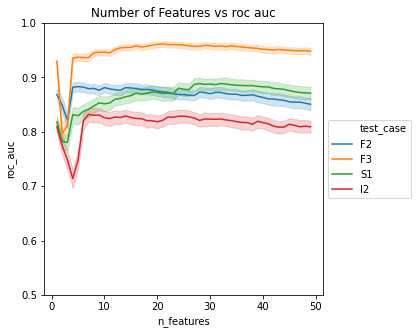

In [101]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='roc_auc',hue='test_case', data=summary_n_features)
plt.ylim([0.5,1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

In [102]:
summary_n_features

,precision,recall,f1,balanced_accuracy,roc_auc,num_feat,n_obs,roc_auc_2,name,n_features,test_case
0,0.582090,1.000000,0.735849,0.562500,0.930288,1,358,0.930288,LogisticRegression,1,F2
1,0.602941,0.976190,0.745455,0.538095,0.869048,1,358,0.869048,LogisticRegression,1,F2
2,0.528571,1.000000,0.691589,0.528571,0.802317,1,358,0.802317,LogisticRegression,1,F2
3,0.557143,1.000000,0.715596,0.515625,0.925481,1,358,0.925481,LogisticRegression,1,F2
4,0.606061,0.952381,0.740741,0.542857,0.820635,1,358,0.820635,LogisticRegression,1,F2
...,...,...,...,...,...,...,...,...,...,...,...
45,0.916667,0.647059,0.758621,0.795752,0.853758,49,350,0.853758,LogisticRegression,49,I2
46,0.750000,0.804878,0.776471,0.712784,0.800673,49,350,0.800673,LogisticRegression,49,I2
47,0.666667,0.666667,0.666667,0.684685,0.748567,49,350,0.748567,LogisticRegression,49,I2
48,0.818182,0.692308,0.750000,0.746154,0.850427,49,350,0.850427,LogisticRegression,49,I2


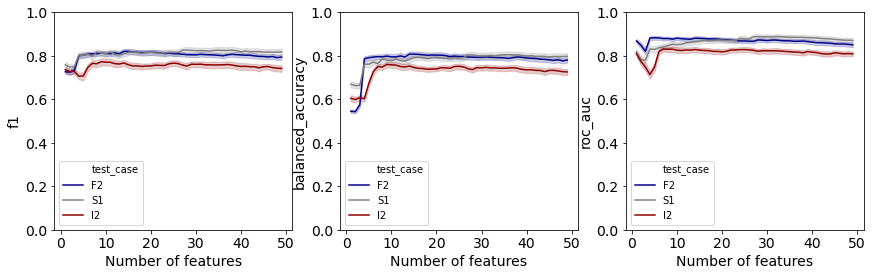

In [103]:
fig=plt.figure(figsize=(14.5, 4))
metrics = ['f1', 'balanced_accuracy', 'roc_auc']
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.lineplot(x='n_features',y=metrics[i],hue='test_case', data=summary_n_features[summary_n_features['test_case']!='F3'], palette=['darkblue', 'gray', 'darkred'])
    plt.ylim(0, 1)
    #plt.title('Number of Features vs {}'.format(metrics[i]), fontsize=14)
    plt.ylabel(metrics[i], fontsize=14)
    plt.xlabel('Number of features', fontsize=14)
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
plt.savefig('figures/1_vs_panel.png', dpi=120, bbox_inches='tight')

In [104]:
combined = summary_n_features.groupby(['test_case','n_features']).mean()

best = combined.sort_values(by='f1', ascending=False).groupby('test_case').head(1)
best

,,precision,recall,f1,balanced_accuracy,roc_auc,num_feat,n_obs,roc_auc_2
test_case,n_features,,,,,,,,
S1,28,0.820613,0.838379,0.826767,0.804326,0.888825,28,350,0.888825
F3,21,0.878035,0.780296,0.822877,0.870872,0.961695,21,358,0.961695
F2,14,0.846504,0.801482,0.820944,0.807893,0.881242,14,358,0.881242
I2,9,0.780286,0.770973,0.773043,0.760441,0.830920,9,350,0.830920


In [105]:
combined

precision    recall        f1  balanced_accuracy  \
test_case n_features                                                     
F2        1            0.579261  0.984016  0.726893           0.544870   
          2            0.578489  0.980488  0.725120           0.543225   
          3            0.597401  0.961577  0.734007           0.575676   
          4            0.826520  0.778609  0.799677           0.786686   
          5            0.833631  0.778891  0.803274           0.791607   
...                         ...       ...       ...                ...   
S1        45           0.817172  0.821327  0.817113           0.795374   
          46           0.819433  0.819943  0.817495           0.796954   
          47           0.819923  0.818689  0.816968           0.796581   
          48           0.820858  0.818533  0.817322           0.796898   
          49           0.821544  0.818555  0.817640           0.797666   

                       roc_auc  num_feat  n_obs  roc_auc_2  
test_case n_features                                        
F2        1           0.868432         1    358   0.868432  
          2           0.849222         2    358   0.849222  
          3           0.820942         3    358   0.820942  
          4           0.881775         4    358   0.881775  
          5           0.883116         5    358   0.883116  
...                        ...       ...    ...        ...  
S1        45          0.875755        45    350   0.875755  
          46          0.873850        46    350   0.873850  
          47          0.872345        47    350   0.872345  
          48          0.871720        48    350   0.871720  
          49          0.871102        49    350   0.871102  

[196 rows x 8 columns]

In [106]:
single_protein = combined[combined['num_feat']==1]
single_protein

,,precision,recall,f1,balanced_accuracy,roc_auc,num_feat,n_obs,roc_auc_2
test_case,n_features,,,,,,,,
F2,1,0.579261,0.984016,0.726893,0.544870,0.868432,1,358,0.868432
F3,1,0.000000,0.000000,0.000000,0.500000,0.929742,1,358,0.929742
I2,1,0.597710,0.973186,0.736352,0.604663,0.809776,1,350,0.809776
S1,1,0.673113,0.874639,0.758424,0.669052,0.818146,1,350,0.818146


In [107]:
one_vs_panel = pd.concat([best, single_protein]).sort_values(by='test_case')
one_vs_panel.to_csv('tables/1_vs_panel.csv')
one_vs_panel

precision    recall        f1  balanced_accuracy  \
test_case n_features                                                     
F2        14           0.846504  0.801482  0.820944           0.807893   
          1            0.579261  0.984016  0.726893           0.544870   
F3        21           0.878035  0.780296  0.822877           0.870872   
          1            0.000000  0.000000  0.000000           0.500000   
I2        9            0.780286  0.770973  0.773043           0.760441   
          1            0.597710  0.973186  0.736352           0.604663   
S1        28           0.820613  0.838379  0.826767           0.804326   
          1            0.673113  0.874639  0.758424           0.669052   

                       roc_auc  num_feat  n_obs  roc_auc_2  
test_case n_features                                        
F2        14          0.881242        14    358   0.881242  
          1           0.868432         1    358   0.868432  
F3        21          0.961695        21    358   0.961695  
          1           0.929742         1    358   0.929742  
I2        9           0.830920         9    350   0.830920  
          1           0.809776         1    350   0.809776  
S1        28          0.888825        28    350   0.888825  
          1           0.818146         1    350   0.818146

In [108]:
best_dict = {}
for i, j in best.index.to_list():
    best_dict[i] = j
best_dict

{'S1': 28, 'F3': 21, 'F2': 14, 'I2': 9}

### Top k selected proteins for prediction
[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information. 

Each endpoint will yield different `top-k` proteins. An aggregation strategy in the simplest form is to combine the top-k. Maybe there is also some kind of rank-algorithm combining the top-k minimizing the overall rank?

In [109]:
protein_panels={}

for end_point, dichotomy in targets_dict.items():
    k=best_dict[end_point]
    feature_selected = FeatureSelector(k=k, protein_gene_data=key_ProteinID)
    protein_panels[end_point] = feature_selected.fit(data_proteomics, dichotomy, end_point)

    
proteins_selected_f2=protein_panels['F2']
proteins_selected_f3=protein_panels['F3']
proteins_selected_s1=protein_panels['S1']
proteins_selected_I2=protein_panels['I2']

In [110]:
proteins_selected_f2.T

Protein ID,P10643,P19320,Q16270,P35858,P02743,A0A0G2JMB2,O00391,Q08380,P01833,P00739,A0A0A0MRZ8,Q99650,Q9Y5Y7,Q15582
F2,C7,VCAM1,IGFBP7,IGFALS,APCS,IGHA2,QSOX1,LGALS3BP,PIGR,HPR,IGKV3D-11,OSMR,LYVE1,TGFBI


In [111]:
proteins_selected_f3.T

Protein ID,P10643,P19320,O00391,P02743,Q16270,Q08380,A0A286YEY1,P27169,Q9Y5Y7,P51884,...,P05546,A0A0G2JMB2,Q99650,P01834,P35858,P01619,K7ERI9,Q15485,Q15582,P0DOY2
F3,C7,VCAM1,QSOX1,APCS,IGFBP7,LGALS3BP,IGHA1,PON1,LYVE1,LUM,...,SERPIND1,IGHA2,OSMR,IGKC,IGFALS,IGKV3-20,APOC1,FCN2,TGFBI,IGLC2


In [112]:
proteins_selected_s1.T

Protein ID,P05062,Q08380,H7BY64,P06396,C9JPQ9,P19320,Q15582,P55103,P08519,Q92820,...,P43652,P04196,Q9Y5Y7,B0YIW2,P80748,A0A0U1RR20,P09172,P01009,P0C0L5,A0A182DWH7
S1,ALDOB,LGALS3BP,NoGene,GSN,FGG,VCAM1,TGFBI,INHBC,LPA,GGH,...,AFM,HRG,LYVE1,APOC3,IGLV3-21,PRG4,DBH,SERPINA1,C4B,SELENOP


In [113]:
proteins_selected_I2.T

Protein ID,Q08380,P10643,P01833,Q16270,O00391,P10909,P23142,P05362,P05546
I2,LGALS3BP,C7,PIGR,IGFBP7,QSOX1,CLU,FBLN1,ICAM1,SERPIND1


In [114]:
# don't label by gene to retain scoring information (to sort at least by endpoint for importance)
protein_panels_scores={}
for end_point, dichotomy in targets_dict.items():
    k=best_dict[end_point]
    feature_selected = FeatureSelector(k=k)
    protein_panels_scores[end_point] = feature_selected.fit(data_proteomics, dichotomy, end_point)

In [115]:
def get_feature_comp(protein_panel:dict, exclude=[], order=None):
    """Custom processor for dictonary holding multual information DataFrame per endpoint
        from above."""
    for i, (endpoint, _df) in enumerate(protein_panel.items()):
        if endpoint not in exclude:
            if i == 0:
                df_protein_panel = _df
            else:
                df_protein_panel = df_protein_panel.join(_df, how='outer')
    if order:
        df_protein_panel = df_protein_panel[order]
    mask = df_protein_panel.isna()   
    # df_protein_panel.where(mask, other=1).fillna(0).sort_values(by=list, ascending=False)
    return df_protein_panel.sort_values(by=list(df_protein_panel.columns), ascending=False).fillna('-')

df_protein_panel = get_feature_comp(protein_panel=protein_panels_scores, exclude=['F3'], order=['F2', 'I2', 'S1'])
df_protein_panel['Gene Name'] = key_ProteinID.loc[df_protein_panel.index]

In [116]:
pd.set_option('precision', 3)
display(df_protein_panel.head(10))

,F2,I2,S1,Gene Name
Protein ID,,,,
P10643,0.263,0.148,-,C7
P19320,0.201,-,0.085,VCAM1
Q16270,0.193,0.121,-,IGFBP7
P35858,0.191,-,0.0706,IGFALS
P02743,0.15,-,-,APCS
A0A0G2JMB2,0.141,-,-,IGHA2
O00391,0.138,0.107,-,QSOX1
Q08380,0.131,0.177,0.092,LGALS3BP
P01833,0.125,0.122,-,PIGR


In [117]:
len(df_protein_panel)

41

For the four endpoints a total of 41 prot

Only one protein, 

### Executor 

corresponds to main function in a script. Allows changes over all endpoints simultaneously. 

In [118]:
from src.cross_validation import MainExecutorCV
cv_executor = MainExecutorCV(proteomics_data=data_proteomics, clinical_data=data_cli, demographics=demographics, clf_sklearn=clf_sklearn, cutoffs_clinic=cutoffs_clinic)

1. Models based on clinical marker thresholds (Clinical Reference Models) - defined by `cutoffs_clinic`
2. Additional Models based on clinical markers (having no standard cutoffs defined or if data dependent cutoff is wanted) - defined by list `additional_markers`
    - As this depends on the endpoint, it is 
3. Proteomics Models based on protein intensities

Performance depends on the number of available features (varies!) 

Result tables:
- metrics are reported for the test set
- `N_obs` is the number of patients both in the training and testing data set which is split into 80% training and 20% testing splits.

In [119]:
ADD_DEMOGRAPHICS = False
INTERACTION_DEGREE = 1
VERBOSE = False

### Fibrosis

#### F2

In [120]:
kleiner_ge_2.value_counts(dropna=False)

1    200
0    160
Name: kleiner, dtype: int64

In [121]:
cutoffs_f2 = cutoffs_clinic['F2'].dropna().to_dict()
cutoffs_f2

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

In [122]:
y = kleiner_ge_2.astype(int)
y.describe()

count    360.000
mean       0.556
std        0.498
min        0.000
25%        0.000
50%        1.000
75%        1.000
max        1.000
Name: kleiner, dtype: float64

In [123]:
f2_results, f2_auc_scores, f2_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_2,
                                                       endpoint='F2',
                                                       additional_markers=['forns', 'p3np'],
                                                       proteins_selected=proteins_selected_f2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=VERBOSE)
result_table_f2 = _get_cv_means(f2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f2

variable                 precision        recall            f1         \
statistics                    mean    std   mean    std   mean    std   
F2_prot_Logistic             0.845  0.062  0.800  0.054  0.820  0.042   
F2_marker_elf_Logistic       0.766  0.083  0.823  0.048  0.790  0.045   
F2_marker_te                 0.760  0.068  0.821  0.051  0.788  0.047   
F2_marker_swe                0.795  0.054  0.776  0.055  0.784  0.041   
F2_marker_te_Logistic        0.848  0.076  0.734  0.073  0.783  0.050   
F2_marker_ft_Logistic        0.844  0.074  0.735  0.071  0.782  0.052   
F2_marker_swe_Logistic       0.857  0.057  0.711  0.065  0.775  0.047   
F2_marker_forns_Logistic     0.721  0.064  0.772  0.062  0.743  0.041   
F2_marker_fib4               0.743  0.058  0.744  0.051  0.742  0.044   
F2_marker_p3np_Logistic      0.819  0.071  0.665  0.068  0.731  0.051   
F2_marker_elf                0.573  0.057  0.995  0.010  0.725  0.047   
F2_marker_fib4_Logistic      0.789  0.082  0.674  0.059  0.723  0.046   
F2_marker_apri_Logistic      0.786  0.089  0.669  0.056  0.718  0.043   
F2_marker_apri               0.835  0.079  0.564  0.064  0.670  0.058   
F2_marker_ft                 0.910  0.065  0.493  0.069  0.637  0.063   

variable                 balanced_accuracy        roc_auc        num_feat  \
statistics                            mean    std    mean    std     mean   
F2_prot_Logistic                     0.808  0.039   0.884  0.034     14.0   
F2_marker_elf_Logistic               0.755  0.046   0.851  0.034      1.0   
F2_marker_te                         0.757  0.040   0.757  0.040      1.0   
F2_marker_swe                        0.768  0.036   0.768  0.036      1.0   
F2_marker_te_Logistic                0.789  0.041   0.873  0.033      1.0   
F2_marker_ft_Logistic                0.791  0.045   0.867  0.035      1.0   
F2_marker_swe_Logistic               0.785  0.037   0.881  0.029      1.0   
F2_marker_forns_Logistic             0.701  0.034   0.809  0.033      1.0   
F2_marker_fib4                       0.711  0.038   0.711  0.038      1.0   
F2_marker_p3np_Logistic              0.747  0.044   0.804  0.039      1.0   
F2_marker_elf                        0.533  0.017   0.533  0.017      1.0   
F2_marker_fib4_Logistic              0.724  0.043   0.788  0.043      1.0   
F2_marker_apri_Logistic              0.721  0.042   0.766  0.043      1.0   
F2_marker_apri                       0.712  0.043   0.712  0.043      1.0   
F2_marker_ft                         0.719  0.039   0.719  0.039      1.0   

variable                       n_obs      roc_auc_2         
statistics                std   mean  std      mean    std  
F2_prot_Logistic          0.0  358.0  0.0     0.884  0.034  
F2_marker_elf_Logistic    0.0  349.0  0.0     0.851  0.034  
F2_marker_te              0.0  341.0  0.0     0.757  0.040  
F2_marker_swe             0.0  331.0  0.0     0.768  0.036  
F2_marker_te_Logistic     0.0  341.0  0.0     0.873  0.033  
F2_marker_ft_Logistic     0.0  268.0  0.0     0.867  0.035  
F2_marker_swe_Logistic    0.0  331.0  0.0     0.881  0.029  
F2_marker_forns_Logistic  0.0  356.0  0.0     0.809  0.033  
F2_marker_fib4            0.0  352.0  0.0     0.711  0.038  
F2_marker_p3np_Logistic   0.0  319.0  0.0     0.804  0.039  
F2_marker_elf             0.0  349.0  0.0     0.533  0.017  
F2_marker_fib4_Logistic   0.0  352.0  0.0     0.788  0.043  
F2_marker_apri_Logistic   0.0  353.0  0.0     0.766  0.043  
F2_marker_apri            0.0  353.0  0.0     0.712  0.043  
F2_marker_ft              0.0  268.0  0.0     0.719  0.039

In [124]:
assert result_table_f2.loc['F2_prot_Logistic', ('roc_auc', 'mean')] - 0.8812105411992736 < 0.00001, "Final results not reproduced."

AssertionError: Final results not reproduced.

#### F3

In [ ]:
kleiner_ge_3.value_counts(dropna=False)

In [ ]:
cutoffs_f3 = cutoffs_clinic['F3'].dropna().to_dict()
cutoffs_f3

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [ ]:
f3_results, f3_auc_scores, f3_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_3, endpoint='F3', 
                                                       additional_markers=['p3np'], 
                                                       proteins_selected=proteins_selected_f3,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=VERBOSE)
result_table_f3 = _get_cv_means(f3_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f3

Using one of the models (or the ensemble), one could expect some predictions of fibrosis patients in the untested healthy patient (hp) cohort.

### Inflamation

In [ ]:
inflamation_ge_2.value_counts(dropna=False)

In [ ]:
cutoffs_i2 = cutoffs_clinic['I2'].dropna().to_dict()
cutoffs_i2

In [ ]:
i2_results, i2_auc_scores, i2_prc_scores = cv_executor.run_evaluation(y=inflamation_ge_2, endpoint='I2', 
                                                       additional_markers=['m30', 'm65', 'alt', 'ast', 'm30m65_ratio'], 
                                                       proteins_selected=proteins_selected_I2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=VERBOSE)
result_table_i2 = _get_cv_means(i2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_i2

### Steatosis

In [ ]:
steatosis_ge_1.value_counts(dropna=False)

In [ ]:
cutoffs_s1 = cutoffs_clinic['S1'].dropna().to_dict()
cutoffs_s1

In [ ]:
y = steatosis_ge_1.astype(int)
y.describe()

In [ ]:
s1_results, s1_auc_scores, s1_prc_scores = cv_executor.run_evaluation(y=steatosis_ge_1, endpoint='S1', 
                                                       additional_markers=[], 
                                                       proteins_selected=proteins_selected_s1,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=VERBOSE)
result_table_s1 = _get_cv_means(s1_results).sort_values(('f1', 'mean'), ascending = False)
result_table_s1

### Write results to Excel

In [ ]:
FILE_RESULTS = os.path.join(TABLEFOLDER, 'CV_results.xlsx')

with pd.ExcelWriter(FILE_RESULTS) as writer:
    result_table_f2.to_excel(writer, sheet_name='F2_featureOptim')
    result_table_f3.to_excel(writer, sheet_name='F3_featureOptim')
    result_table_i2.to_excel(writer, sheet_name='I2_featureOptim')
    result_table_s1.to_excel(writer, sheet_name='S1_featureOptim')

## Plot Results of Cross validation for three endpoints (F2, I2, S1)

- create [enumeration of subplots](https://stackoverflow.com/a/25544329/9684872) starting at a)

In [ ]:
map_names = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'naming_scheme.csv'), index_col='name_in_clinical_data')
map_names = map_names['name_in_plot'].to_dict()
map_names

Custom function to transform index names

In [ ]:
display(result_table_s1)

def _process_names(index, map_names=map_names):
    """Helper function for custom labeling of models.
    This function is specific to any dataset and has to be rewritten.
    
    Parameters
    ----------
    index: pandas.Index
        Index to transform. Index names are composite word
        combined with '_' here.
    map_names: dict
        Mapping of names to apply to words.
    """
    names = list(index)
    names = [x.split('_') for x in names]
    endpoint = names[0][0]
    
    def _process_index_names(_l:list):
        REMOVE = 'marker'
        if REMOVE in _l:
            _l.remove(REMOVE)
        _l = [word if not word in map_names else map_names[word] for word in _l]
        CHANGE = {'Logistic': 'Model',
                  'prot': 'Proteomics'}
        _l = [word if not word in CHANGE else CHANGE[word] for word in _l]
        if CHANGE['Logistic'] not in _l:
            _l.append('Test')
        return _l
    
    for _l in names: assert endpoint == _l[0] , f"Mixed endpoints: {endpoint} and {_l[0]}"
    names = [" ".join(_process_index_names(_l[1:])) for _l in names]
    return names

_process_names(result_table_s1.index)

### Performance Plots based on results DataFrame for a endpoint

In [ ]:
from src.plots import plot_performance
fig, ax = plt.subplots(figsize=(10,10))
plot_performance(ax, result_table_s1, 'balanced_accuracy', 'Steatosis', _process_index=_process_names)

### AUC-ROC Curves based on CV result for an endpoint

In [ ]:
from src.plots import plot_roc_curve

fig, ax = plt.subplots(figsize=(8, 8))      
        
plot_roc_curve(ax, roc_curve_results['F2_Logistic'], 'TARGET')

### Precision Recall Curve

In [ ]:
from src.plots import plot_prc_curve
fig, ax = plt.subplots(figsize=(8, 8))
plot_prc_curve(ax, precision_recall_results['F2_Logistic'], 'TARGET')

### Build final figure for publication

In [ ]:
result_table_f3

In [ ]:
import string
fig, axs = plt.subplots(3,3,figsize=(20,20))

n=0
result_tuples = [
 (result_table_f2, f2_auc_scores, 'Fibrosis F2-F4', 'F2_prot_Logistic'), 
 (result_table_i2, i2_auc_scores, 'NAS Inflamation $\geq 2$', 'I2_prot_Logistic'), 
 (result_table_s1, s1_auc_scores, 'NAS Steatosis $\geq 5$%', 'S1_prot_Logistic'), 
    
]

for col, (result_table, result_auc_scores, endpoint_title, auc_model_name) in enumerate(result_tuples):
    
    ax = axs[0,col]
    plot_roc_curve(ax, result_auc_scores[auc_model_name], endpoint_title)
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[1,col]
    plot_performance(ax, result=result_table, metric='f1', title=endpoint_title,  _process_index=_process_names)   
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[2,col]
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    plot_performance(ax, result=result_table, metric='balanced_accuracy', title=endpoint_title, _process_index=_process_names)   

    n+=1

fig.tight_layout()
fig.savefig(FIGURE_FOLDER / 'Figure_6_new.png', dpi=120, pad_inches=0.1, bbox_inches='tight')

- plot for model ≥ F3

## Final model

1. Either pick one of the models run during CV
2. Aggregate metrics over all CV runs for obs in test set (~ mean of CV results)
3. Perform new train/test split.


Steps to implement

1.  Select model with median aucroc performance
2.  Report summary statistics (mean, median, min, max)
3.  [DeLong](https://github.com/llniu/roc_comparison)
4.  Target Scores for three endpoints of final prediction model


### Check Cross Validation results (for comparison)

#### Look at descriptive statistics of CV

- depending on the split the performance varies. The `min`, `max`, `mean`, etc. are given per model, therefore it's not the given split. Selecting a split of the data which supports one's conclusion can be misleading.

In [ ]:
results = {
 "F2":f2_results,
 "F3":f3_results,
 "I2":i2_results,
 "S1":s1_results
}

In [ ]:
results_combinded = {}
for _results in results.values(): results_combinded.update(_results)
results_combinded.keys()

In [ ]:
def show_summary(results_dict, metric='f1', sort=True, save=False):
    _df = pd.DataFrame(results_dict).loc[metric].apply(pd.Series).T.describe()
    _df.index.name = metric
    if sort:
        _df = _df.sort_values(by='mean', axis=1, ascending=False)
    if save:
        fname = "cv_stats_{}{}.xlsx".format(metric, '_sorted' if save else '')
        fname = os.path.join(TABLEFOLDER, fname)
        _df.to_excel(fname)
        print(f'Saved Table to: {fname}')
    return _df

In [ ]:
out= widgets.interact(show_summary, metric=scoring, results_dict=widgets.fixed(results_combinded))

#### Select a model from the CV run (and compare it to others)

In [ ]:
l_models = list(results_combinded.keys())
ref_model=l_models[14] # 'F2_prot_Logistic'
metric=scoring[2]      # 'f1'

In [ ]:
def compare_models(ref_model:str, metric:str, data:dict, fct=np.median):
    """Select comparison. The first column is the referenc model.
    If the metric of the summary statistic is present several times in the model, this value is returned."""
    ref_model_metric_values = np.array(data[ref_model][metric])
    ref_model_metric = fct(ref_model_metric_values)
    ref_model_metric_idx = (np.abs(ref_model_metric_values - ref_model_metric)).argmin() #ToDo: return both closest values for median.
    ref_model_metric = ref_model_metric_values[ref_model_metric_idx]
    matches = [index for index, item in enumerate(ref_model_metric_values) if item == ref_model_metric]

    _results = pd.DataFrame(ref_model_metric_values[matches], columns=[ref_model], index=matches)
    _results.index.name = 'run'
    
    _selected_results = {}
    
    
    for _model, _result in data.items():
        if not _model == ref_model:
            _selected_results[_model] = [_result[metric][item] for item in matches]
    #sorting of values over last result
    _other = pd.DataFrame(_selected_results, index=matches)
    _other = _other.sort_values(by=matches[-1], axis=1, ascending=False)
    return _results.join(_other)

# compare_models(ref_model=ref_model, metric='precision', data=f2_results, fct=lambda x: np.quantile(x, q=0.6))

In [ ]:
protein_model_name = {endpoint: f'{endpoint}_prot_Logistic'for endpoint in end_points}
metrics_np_fct = {'median': np.median, '3rd quintile': lambda x: np.quantile(x, q=0.6), 'mean': np.mean, 'max': np.max, 'min': np.min }

#needs global dictionaries: protein_model_name, metrics_np_fct, results
def _caller_comp(metric, endpoint, selector):
    """Helper function to use with ipykernel"""
    df = compare_models(ref_model=protein_model_name[endpoint], metric=metric, data=results[endpoint], fct=metrics_np_fct[selector])
    df.columns.name = selector
    return df
# _caller_comp('f1', 'I2', 'median')

In [ ]:
out2= widgets.interact(_caller_comp, metric=scoring, endpoint=results.keys(), selector=metrics_np_fct.keys())

### Train a new final model

Adjust `run_cv_binary`

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_cli_missing_table, stratifier, test_size=0.2, stratify=stratifier, random_state=42)
logging.info(f"N train: {len(y_train)}")
logging.info(f"N test: {len(y_test)}")

In [ ]:
combine_value_counts(pd.DataFrame({'train': y_train, 'test': y_test}))

In [ ]:
train_test_split_final = [(X_train.index, X_test.index)] # list of (train, test) indices. Does not throw a nice error message otherwise.

Adapted the executor to take as argument a different function.

In [ ]:
arguments = {}
arguments['F2'] = {'target': kleiner_ge_2, 'proteins': proteins_selected_f2, 'add_markers': ['forns', 'p3np']} 
arguments['F3'] = {'target': kleiner_ge_3, 'proteins': proteins_selected_f3, 'add_markers': ['p3np']}
arguments['I2'] = {'target': inflamation_ge_2, 'proteins': proteins_selected_I2, 'add_markers': ['m30', 'm65', 'alt', 'ast', 'm30m65_ratio']}
arguments['S1'] = {'target': steatosis_ge_1, 'proteins': proteins_selected_s1, 'add_markers': []}

In [ ]:
ADD_DEMOGRAPHICS = False
FOLDER_FINAL_SCORES = 'final_model_scores'

import importlib; importlib.reload(src.cross_validation)
from src.cross_validation import run_cv_binary
prediction_folder = os.path.join(TABLEFOLDER, FOLDER_FINAL_SCORES)


from functools import partial
run_cv_binary_final = partial(run_cv_binary, save_predictions=True, folder=prediction_folder)


results_final = {}

for endpoint, args in arguments.items():
    results_final[endpoint] = cv_executor.run_evaluation(y=args['target'],
                                                       endpoint=endpoint,
                                                       additional_markers=args['add_markers'],
                                                       proteins_selected=args['proteins'],
                                                       evaluator_fct=run_cv_binary_final,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=train_test_split_final,
                                                       verbose=False)

In [ ]:
def display_result(endpoint):
    return pd.DataFrame(results_final[endpoint][0]).applymap(lambda x: x[0]).T.sort_values('f1', ascending=False)


# pd.DataFrame(results_final['F2'][0]).T.sort_values('f1', ascending=False)
out3= widgets.interact(display_result, endpoint=results_final.keys())

Save results

In [ ]:
results_final_df = {endpoint: display_result(endpoint) for endpoint in results_final.keys()}

RESULTS_FINAL_MODEL = os.path.join(TABLEFOLDER ,'final_model_results.xlsx')

with pd.ExcelWriter(RESULTS_FINAL_MODEL) as writer:
    for sheet_name, _df in results_final_df.items():
        _df.to_excel(writer, sheet_name=sheet_name)

#### DeLong-Test on final model

First a check of the [implementation](https://github.com/yandexdataschool/roc_comparison) by using a toy example derived in detail in Rachel Draelos' [blog-post](https://glassboxmedicine.com/2020/02/04/comparing-aucs-of-machine-learning-models-with-delongs-test/), where she also references the original DeLong paper from 1988 and a paper on a fast implementation described by Xu Sun and Weichao Xu from 2014.

In [ ]:
import numpy as np
from roc_comparison import compare_auc_delong_xu

ground_trouth = np.array([0,0,1,1,1])
pred_model_a  = np.array([0.1,0.2,0.6,0.7,0.8])
pred_model_b  = np.array([0.3,0.6,0.2,0.7,0.9])

log10_pvalue = compare_auc_delong_xu.delong_roc_test(ground_truth=ground_trouth,
                                      predictions_one=pred_model_a,
                                      predictions_two=pred_model_b
                                 )
assert np.round(10**log10_pvalue[0][0], 4) ==  0.3173 

The implementation currently returns an array of an array with a single float. This could be change to an normal array or a plain floating point number:

In [ ]:
log10_pvalue[0][0], log10_pvalue[0] # one of the two

Get list of dumped results from models.

In [ ]:
folder_final_scores = os.path.join(TABLEFOLDER, FOLDER_FINAL_SCORES)
l_scores = [_csv for _csv in os.listdir(folder_final_scores) if 'Logistic.csv' in _csv]
l_scores

Calculate the p-value based on the common subset of samples between models:

In [ ]:
# #view defintion of imported function
#calc_p_value_delong_xu??

Compare all models between all endpoints and highlight the results

In [ ]:
from src.delong import calc_p_value_delong_xu

model_1 = l_scores[0]
model_2 = l_scores[8]

print(
f"Delong-Test p-value between scores of model {model_1.split('.',1)[0]} and {model_2.split('.')[0]}: "
f"{calc_p_value_delong_xu(model_1=model_1, model_2=model_2, folder_dumps=folder_final_scores, verbose=True):.4f}")

In [ ]:
auc_comp_dict = {}

def highlight_significant(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for floats smaller
    equal to 0.05
    """
    color = 'red' if val <= 0.05 else 'black'
    return 'color: %s' % color

for endpoint in end_points:
    # models = [x for x in l_scores if endpoint in x]
    # model_names = [" ".join(x.split('.csv')[0].split('_')) for x in models]
    model_names = pd.DataFrame(results_final[endpoint][0]).applymap(lambda x: x[0]).T.sort_values('f1', ascending=False).index.to_list()
    model_names = [model for model in model_names if 'Logistic' in model]
    models = [f'{name}.csv' for name in model_names]
    _df = pd.DataFrame(0, index=models, columns=models)
    
    for i, model_1 in enumerate(models):
        for model_2 in models[i:]:
            if model_1 == model_2:
                _df.loc[model_1, model_2] = 1.0
            else:
                _auc_p_value = calc_p_value_delong_xu(model_1, model_2, folder_dumps=folder_final_scores)
                _df.loc[model_1, model_2] = _auc_p_value
                _df.loc[model_2, model_1] = _auc_p_value
    model_names = [" ".join(x.split('.csv')[0].split('_')) for x in model_names]
    _df.columns = model_names
    _df.index   = model_names
    _df =  _df.style.applymap(highlight_significant)
    display(_df)
    auc_comp_dict[endpoint] = _df

Save results for supplementary materials:

In [ ]:
FILE_DELONG = Path(TABLEFOLDER) / 'compare_delong.xlsx'

with pd.ExcelWriter(FILE_DELONG) as writer:
    auc_comp_dict['F2'].to_excel(writer, sheet_name='F2')
    auc_comp_dict['I2'].to_excel(writer, sheet_name='I2')
    auc_comp_dict['S1'].to_excel(writer, sheet_name='S1')

## Final Model evaluation

The healthy patients in the study - have been selected based on age and gender range of the non-healthy patients. These have an `NaN` assigned on the three endpoints.
Another group has been previously excluded from the analysis and can be used here as an pseudo external dataset 

> Note: Pseudo as for now all proteomics pre-processing is done on the entire dataset. Either the procedure is done individuelly for each subset of patients, 
or the mean and std deviation from the training dataset are used to sample random values for missing protein intensities on the test data. The standardisation of the 
proteins intensities after imputation should ideally also be based on the statistics from the training data (which is assumed to the "global" value").

Patiens with an assigned fibrosis score of `0.5` are known to be heavy drinkers without being diagnosed with a fibrosis.

In [ ]:
data_cli_full = pd.read_csv(f_data_clinic, index_col=COL_ID)
# previous selection: data_cli[data_cli['kleiner']!=0.5] 
all_kleiner_score = data_cli_full.kleiner.value_counts(dropna=False)
all_kleiner_score

In [ ]:
#n_healty, n_at_risk = all_kleiner_score.loc[[np.nan, 0.5]]
#One patient in the disease cohort had a 'NaN' kleiner score
n_healthy = data_cli[data_cli['group']=='HP'].shape[0]
n_at_risk = data_cli_full[data_cli_full['kleiner']==0.5].shape[0]
print(f"N Healthy (selected to match ill patients: {n_healthy}")
print(f"N Unhealthy behaviour, but not sick: {n_at_risk}")

In [ ]:
# from src.pandas import combine_value_counts
combine_value_counts(data_cli_full[TARGETS], dropna=False)

In [ ]:
combine_value_counts(data_cli_full.loc[data_cli_full.kleiner == 0.5, TARGETS], dropna=False)

In [ ]:
data_cli_full.loc[data_cli_full.kleiner == 0.5, TARGETS]

#### Load final models

In [ ]:
from joblib import load
endpoints = ['F2', 'I2', 'S1']
fname_final_model = '{}_prot_Logistic.joblib'
final_prot_model = {}
for endpoint in endpoints :
    _fname = os.path.join('tables', FOLDER_FINAL_SCORES, fname_final_model.format(endpoint))
    print(f"Load model from : {_fname}")
    final_prot_model[endpoint] = load(_fname)
    print(final_prot_model[endpoint].coef_)

Protein by endpoint can be retrieved using the previously defined dictionary

In [ ]:
arguments['S1']['proteins'].T

In [ ]:
from src.final_model import FinalPredictor
# FinalPredictor??

In [ ]:
final_predictor = FinalPredictor(data_clinic=data_cli_full, 
                                 data_proteomics=data_proteomics, 
                                 final_models=final_prot_model, 
                                 features_dict=arguments, 
                                 endpoints=endpoints)

### Feature Importance of final models

- how important are the single proteins, assessed by the model weights.

In [ ]:
# protein panel. Some order?
d_model_weights = {}
d_model_intercepts = {}
for _endpoint, _model in final_predictor.final_models.items():
    d_model_weights[_endpoint] = dict(zip(final_predictor.features_dict[_endpoint]['proteins'].index.to_list(), _model.coef_[0]))
    d_model_intercepts[_endpoint] = _model.intercept_[0]
del _endpoint, _model

model_weights = pd.DataFrame(d_model_weights)

model_weights.index =  [f'{_index}_{_gene}' for _index, _gene 
 in key_ProteinID.loc[model_weights.index].to_dict()['Gene names'].items()
]

model_weights = model_weights.append(pd.Series(d_model_intercepts, name='intercept'))
del d_model_weights, d_model_intercepts
model_weights.to_excel(Path(DATAFOLDER) / 'final_model_weights.xlsx') 
new_index = [i.split('_')[1] for i in model_weights.index[:-1]]
new_index.append('intercept')
model_weights.index=new_index
model_weights=model_weights.sort_values(by='F2', ascending=False).iloc[::-1]
model_weights_F2=model_weights[model_weights['F2'].notnull()][['F2']]
model_weights_I2=model_weights[model_weights['I2'].notnull()][['I2']].sort_values(by='I2')
model_weights_S1=model_weights[model_weights['S1'].notnull()][['S1']].sort_values(by='S1')
model_weights

In [ ]:
ax = model_weights.plot(kind='barh', figsize=(3,15), color=['darkblue', 'darkred', 'gray'])
plt.xticks(fontsize=14);
plt.yticks(fontsize=12);
plt.xlabel('final model weights', fontsize=14);
ax.figure.savefig(FIGURE_FOLDER / 'final_model_weights.png', dpi=120, pad_inches=0.1, bbox_inches='tight')

### At risk population

How many patients at risk have been predicted to have a certain disease stage?

In [ ]:
at_risk_score = final_predictor.predict_score(indices=data_cli_full.kleiner[data_cli_full.kleiner == 0.5].index)
at_risk_pred = final_predictor.predict(indices=data_cli_full.kleiner[data_cli_full.kleiner == 0.5].index)

In [ ]:
# minimal check to catch big errors
from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(x=at_risk_score.loc['Plate4_D9'].values,  
                          y=[0.539575564, 0.659919782,0.931215122])

In [ ]:
def highlight_surpassed_score(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for floats smaller
    equal to 0.05
    """
    color = 'yellow' if val >= 0.5 else None
    return f'background-color: {color}'

In [ ]:
at_risk_score = at_risk_score.sort_values(by=list(at_risk_score.columns), ascending=False).style.applymap(highlight_surpassed_score)
at_risk_pred = at_risk_pred.loc[at_risk_score.index]
at_risk_pred.head()

In [ ]:
def build_results_table(predictions:pd.DataFrame, dropna=True):
    """Convert a table of predicitons (for several columns) into a result table."""
    predictions_tab = combine_value_counts(predictions)
    predictions_tab = predictions_tab.join(combine_value_counts(predictions, dropna=dropna) / len(predictions), rsuffix='_freq')
    predictions_tab.loc['Total'] = predictions_tab.sum()
    return predictions_tab.convert_dtypes()

at_risk_results_tab  = build_results_table(at_risk_pred)
at_risk_results_tab

In [ ]:
# ToDo: move to src (replace index building in cross_validation._get_cv_means)
def build_two_level_index(initial_columns, present_key='freq', added_key='prop'):
    """Build a custom multi-index object for data. The initial columns to build the 
    data object are passed along the key describing the intial data and added information by 
    a second key. Could be generalized to work with any number of keys."""
    column_map = []
    for x in initial_columns:
        column_map += [x, x + '_freq']

    levels = [initial_columns, [present_key, added_key]]
    multi_index = pd.MultiIndex.from_product(
        levels, names=['variable', 'statistics'])
    return column_map, multi_index

column_map, multi_index = build_two_level_index(initial_columns=at_risk_pred.columns)
at_risk_results_tab = at_risk_results_tab[column_map]
at_risk_results_tab.columns = multi_index
at_risk_results_tab

### Healthy

How many healthy patients would be predicted to have fibrosis by the final model?

Here we check for formally "healthy" patients (they have not been diagnosed at the initial time of the data collection) and see who would be predicted to 
have a fibrosis score of 2 and above.

We will predict for patients without a fibriosis score. We load the **final** proteomics model from the previous step, lookup the blood plasma protein intensities for these patients on the selected proteins for the classification model, and finally predict their outcome.

In [ ]:
data_cli.fibrosis_class.value_counts(dropna=False)

In [ ]:
data_cli[data_cli['group']=='HP'].shape

In [ ]:
healthy_cohort_mask = data_cli[data_cli['group']=='HP']
healthy_cohort_indices = healthy_cohort_mask.index
healthy_pred = final_predictor.predict(indices=healthy_cohort_indices)
healthy_risk_score = final_predictor.predict_score(indices=healthy_cohort_indices)
healthy_risk_score = healthy_risk_score.sort_values(by=list(healthy_risk_score.columns), ascending=False).style.applymap(highlight_surpassed_score)
healthy_pred = healthy_pred.loc[healthy_risk_score.index]

In [ ]:
healthy_results_tab  = build_results_table(healthy_pred)
column_map, multi_index = build_two_level_index(initial_columns=healthy_pred.columns)
healthy_results_tab = healthy_results_tab[column_map]
healthy_results_tab.columns = multi_index
healthy_results_tab

Of the healty cohort 8 patients are predicted to have a form of advanced fibrosis, which is a share of 5.8% of the patients in this cohort

It is claimed that in the general population a percentage of x has an undiagnosed liver disease. Does our percentage match this?

### Write results

In [ ]:
excel_sheets = {'at_risk_results': at_risk_results_tab,
                'at_risk_pred':at_risk_pred,
                'at_risk_score': at_risk_score,
                'healthy_results': healthy_results_tab, 
                'healthy_pred': healthy_pred,
                'heatlhy_score': healthy_risk_score}
FILE_FINAL_MODEL_EVALUATION = os.path.join(TABLEFOLDER ,'final_model_evaluation.xlsx')

with pd.ExcelWriter(FILE_FINAL_MODEL_EVALUATION) as writer:
    for sheet_name, _df in excel_sheets.items():
        _df.to_excel(writer, sheet_name=sheet_name)

### Extract predicted positive cases and concordance with other non-invasive markers
- F2: swe , te. Cut-offs for ≥F2: 8.6kPa for swe and 7kPa for te
- I2: no equivalent 
- S1: cap. Cut-offs for ≥S1: 290
- Values above cut-offs are color-coded

In [ ]:
try:
    doubleID=pd.read_csv('data/raw/DoubleIDkey.csv', index_col=False)
    display(doubleID)
except:
    doubleID=None

### At risk population

In [ ]:
at_risk_pred_pos_all = at_risk_pred[at_risk_pred.max(axis=1)==1]
data_cli_atrisk = data_cli_full[data_cli_full['kleiner']==0.5]

In [ ]:
at_risk_pos = at_risk_pred_pos_all.join(data_cli_atrisk[['swe', 'te', 'cap']], how='left')
if not doubleID.empty:
    at_risk_pos = at_risk_pos.join(doubleID.set_index('Sample ID'), how='left')
m=at_risk_pos.style.apply(lambda x: ['background: yellow' if v>0 else "" for v in x],
                        subset=['F2', 'I2', 'S1'], axis=1)
m.apply(lambda x:['background: pink' if v>290 else"" for v in x],
             subset=['cap'], axis=0)
os.makedirs(os.path.join('tables', 'validation'), exist_ok=True)
m.data.to_csv('tables/validation/predicted_scores_at_risk_postive.csv')
m

### Healthy population

In [ ]:
healthy_pred_pos_all = healthy_pred[healthy_pred.max(axis=1)==1]

In [ ]:
healthy_pos = healthy_pred_pos_all.join(data_cli[['swe', 'te', 'cap']], how='left')
if not doubleID.empty:
    healthy_pos = healthy_pos.join(doubleID.set_index('Sample ID'), how='left')
l=healthy_pos.style.apply(lambda x: ['background: yellow' if v>0 else "" for v in x],
                        subset=['F2', 'I2', 'S1'], axis=1)
l.apply(lambda x:['background: pink' if v>290 else"" for v in x],
             subset=['cap'], axis=0)
l.data.to_csv('tables/validation/predicted_scores_healthy_postive.csv')
l

### Plot predicted score distribution from the final model in three populations
- healthy population (N=136).
- at risk population (N=98). Heavy alcohol drinkers but benigh liver
- high risk population (N=72). Healvy alcohol drinkers with various forms of liver injuries 

In [ ]:
final_model_test_score = final_predictor.predict_score(indices=train_test_split_final[0][1])
final_model_test_score = final_model_test_score.sort_values(by=list(final_model_test_score.columns), ascending=False)

In [ ]:
model_naming = {'F2':'Fibrosis F2-F4', 'I2':'NAS Inflamation $\geq 2$', 'S1':'NAS Steatosis $\geq 5$%'}
def plot_score_distribution(ax, endpoint):
    ax = sns.kdeplot(data=healthy_risk_score.data[endpoint], label='healthy', color='steelblue', shade=True, ax=ax, cut=0)
    ax = sns.kdeplot(data=at_risk_score.data[endpoint], label='at risk', color='darkorange', shade=True, ax=ax, cut=0)
    ax = sns.kdeplot(data=final_model_test_score[endpoint], label='high risk', color='red', shade=True, ax=ax, cut=0)
    ax.set_xlabel('Risk score predicted by\n proteomic model')
    ax.set_xlim(-0.0, 1.0)
    ax.set_title(model_naming[endpoint])
    return ax

In [ ]:
fig, axes = plt.subplots(ncols=3,figsize=(12,4))
for i, endpoint in enumerate(['F2', 'I2', 'S1']):
    plot_score_distribution(axes[i], endpoint)
fig.savefig(FIGURE_FOLDER / 'Score_kde_all', dpi=120, bbox_inches='tight')

In [ ]:
for endpoint in ['F2', 'I2', 'S1']:
    fig, ax = plt.subplots(figsize=(4,4))
    plot_score_distribution(ax, endpoint)
    fig.savefig(FIGURE_FOLDER / 'Score_kde_{}'.format(endpoint), dpi=120, bbox_inches='tight')

In [ ]:
def plot_score_hist(ax, data, label, color, bins=10, kde=False, rug=True):
    ax = sns.distplot(data, ax=ax, label=label, color=color, bins=bins, kde=kde, rug=rug)
    ax.set_xlabel('Risk score predicted by\n proteomic model')
    ax.set_xlim(-0.0, 1.0)
    ax.set_title(label)
    return 

for endpoint in ['F2', 'I2', 'S1']:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    plot_score_hist(ax=axes[0], data=healthy_risk_score.data[endpoint], bins=10, label='healthy',   color='steelblue', kde=False, rug=True)
    plot_score_hist(ax=axes[1], data=at_risk_score.data[endpoint],      bins=10, label='at risk',   color='darkorange',kde=False, rug=True)
    plot_score_hist(ax=axes[2], data=final_model_test_score[endpoint],  bins=10, label='high risk', color='red',       kde=False, rug=True)
    fig.suptitle(model_naming[endpoint])
    fig.savefig(FIGURE_FOLDER / 'Score_hist_{}'.format(endpoint), dpi=120, bbox_inches='tight')

The rugs (small vertical lines at the botoom of the figure) indicate a single prediction. The scores are devided in 10 bins which means that each bin is decimal range (0.0 to 0.1, 0.1 to 0.2 and so forth).

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
for i, endpoint in enumerate(['F2', 'I2', 'S1']):
    sns.distplot(healthy_risk_score.data[endpoint], ax=axes[i, 0], bins=10, label='healthy',   axlabel=False, color='steelblue', kde=False, rug=True)
    sns.distplot(at_risk_score.data[endpoint],      ax=axes[i, 1], bins=10, label='at risk',   axlabel=False, color='darkorange',kde=False, rug=True)
    sns.distplot(final_model_test_score[endpoint],  ax=axes[i, 2], bins=10, label='high risk', axlabel=False, color='red',       kde=False, rug=True)

pad = 5 # in point
for i, (_title, _endpoint) in enumerate(zip(['healthy', 'at risk', 'high risk'], ['F2', 'I2', 'S1'])):
    axes[-1, i].set_xlabel('Risk score predicted by\n proteomic model')
    axes[0, i].set_title(_title)
    _ax = axes[i, 0]
    _ax.set_ylabel('frequency')
    _ax.annotate(_endpoint, xy=(0, 0.5), 
                 xytext=(-_ax.yaxis.labelpad - pad, 0),
                xycoords=_ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
_ = fig.suptitle('Histograms by endpoint', y=.93, fontsize=16 )
fig.savefig(FIGURE_FOLDER / 'Score_hist_all', dpi=120, bbox_inches='tight')

# Python Package Versions

In [ ]:
!pip list | grep pandas

In [ ]:
!pip list | grep scikit

Find the packages in the `requirements.txt` or `environment.yml`

In [ ]:
# %load environment.yml